In [1]:
'''
Aim: get differential expressed interactions
Author:Yike Xie
Date: Jan 2023
'''

'\nAim: get differential expressed interactions\nAuthor:Yike Xie\nDate: Jan 2023\n'

In [2]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rcParams

import seaborn as sns

In [3]:
save_figures = '/home/yike/phd/dengue/docs/paper_draft/figures/YK_figures/exclude_1_075_01/figure6/'

In [4]:
res = pd.read_excel('/home/yike/phd/dengue/data/Luca_cyto_exp.xlsx', sheet_name='results', skiprows=[0])

# exclude VCAM1
cols = res.columns.tolist()
cols.remove('VCAM1')
res = res[cols]

# exclude patient 1_075_01
res = res[~ (res['ID'] == '1_075_01')]
res = res.set_index(['Condition', 'ID'])
res = res.replace(['<0.03', '<3.00', '<4.80'], 0)

res = res.astype('float').loc[['H', 'D', 'DWS', 'SD']]

In [5]:
# pairwise comparison
if False:
    IDs_S = res.loc['SD'].index
    IDs_NS = res.loc['D'].index

    log2_fc = []
    for ID_S in IDs_S:
        avg_S = np.array(res.loc['SD', ID_S])
        for ID_NS in IDs_NS:
            avg_NS = np.array(res.loc['D', ID_NS])

            log2_fc.append(np.log2(avg_S + 1) - np.log2(avg_NS + 1))

    log2_fc = np.asarray(log2_fc)

    med_pair = np.median(log2_fc, axis=0)
    pos_fra_pair = [len(log2_fc[:, i][log2_fc[:, i] > 0])/log2_fc.shape[0] for i in range(log2_fc.shape[1])]
    neg_fra_pair = [len(log2_fc[:, i][log2_fc[:, i] < 0])/log2_fc.shape[0] for i in range(log2_fc.shape[1])]

    pair = pd.DataFrame([], index=res.columns)
    pair['med_pair'] = med_pair
    pair['fra_pair'] = pos_fra_pair
    pair['neg_fra_pair'] = neg_fra_pair

    #############################
    from scipy.stats import ttest_ind, ks_2samp, mannwhitneyu

    ###########################
    # Man-whitney U test
    stats_u = []
    pvalue_u = []

    for gene in res.columns:

    #     if ( res.loc['D'][gene].tolist() == res.loc['SD'][gene].tolist()) == True: 
        if sum(res.loc['D'][gene].tolist()) + sum(res.loc['SD'][gene].tolist()) == 0:
            s, p = 'N/A', 1
            stats_u.append(s)
            pvalue_u.append(p)
            continue

        s, p = mannwhitneyu(res.loc['D'][gene].tolist(), res.loc['SD'][gene].tolist(), alternative='two-sided',)
        stats_u.append(s)
        pvalue_u.append(p)

    pair['statistic_U'] = stats_u
    pair['pvalue_U'] = pvalue_u

    pair['avg_D'] = res.loc['D'].mean()
    pair['avg_SD'] = res.loc['SD'].mean()

    pair = pair.sort_values(['med_pair', 'avg_SD'], ascending=False)

    pair.index.name = 'gene'
    pair['log2_fold_change'] = (np.log2(res[pair.index].loc['SD'].mean(axis=0) + 0.1) - 
                                np.log2(res[pair.index].loc['D'].mean(axis=0) + 0.1))
    pair.to_csv('/home/yike/phd/dengue/docs/paper_draft/tabels/exclude_1_075_01/cytokines/cyto_pair.tsv', 
                sep='\t')

    ##########################
    pair = pd.read_csv('/home/yike/phd/dengue/docs/paper_draft/tabels/exclude_1_075_01/cytokines/cyto_pair.tsv', 
                sep='\t', index_col='gene')
    sig_cytos = pair[pair['pvalue_U'] < 0.05].sort_values(['med_pair', 'avg_SD']).index

In [6]:
pair = pd.read_csv('/home/yike/phd/dengue/docs/paper_draft/tabels/exclude_1_075_01/cytokines/cyto_pair.tsv', 
            sep='\t', index_col='gene')
sig_cytos = pair[pair['pvalue_U'] < 0.05].sort_values(['med_pair', 'avg_SD']).index

##########
ct_pair = pd.read_csv('/home/yike/phd/dengue/docs/paper_draft/tabels/exclude_1_075_01/ct_pair.tsv', 
                      sep=',', index_col=['cell_subtype', 'gene'])

cst_pair = pd.read_csv('/home/yike/phd/dengue/docs/paper_draft/tabels/exclude_1_075_01/cst_pair.tsv', 
                       sep=',', index_col=['cell_subtype', 'gene'])

###########
cts = ['Monocytes', 'NK cells', 'Plasmablasts', 'B cells', 'T cells', 
      'conventional DCs', 'plasmacytoid DCs','megakaryocytes', ]
csts = [
         'classical monocytes',
         'non-classical monocytes',
         'intermediate monocytes',
         
         'cytotoxic NK cells',
         'signaling NK cells',
    
         'proliferating plasmablasts',
         'non-proliferating plasmablasts',
    
         'naive B cells',
         'memory B cells',
         'activated B cells',

         'CD4+ naive T cells',
         'CD4+ memory T cells',
         'CD8+ naive T cells',
         'CD8+ effector memory T cells',
         'CD8+ exhausted T cells',
         'MAIT',
         'Tregs',

         'cDC1',
         'cDC2',
         'pDCs',
         'megakaryocytes',]

In [7]:
def data_show(pair, res, pvalue, cds):
    
    # order of sig cytokines
    idx_ks = pair[pair[pvalue] < 0.05].sort_values(['med_pair', 'avg_SD'], ascending=False).index
    idx_not = [idx for idx in pair.index if idx not in idx_ks]
    # order of unsig cytokines
    idx_ks_rest = pair.loc[idx_not].sort_values(['med_pair', 'avg_SD'], ascending=False).index

    # log the concentration of cytokines
    new_idx = idx_ks.tolist() + idx_ks_rest.tolist()
    all_data_ks = np.log10(res[new_idx].loc[cds].reset_index().set_index('ID')[
        res[new_idx].loc[cds].reset_index().set_index('ID').columns[1:]] + 0.1)
    
    return all_data_ks

def heatmap(res_data, row_colors, title=False):
    rcParams['font.size']=18
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"
    rcParams['figure.dpi'] = 300
    
    cmap = sns.color_palette("vlag", as_cmap=True) # 'vlag', 'Greys'

    g = sns.clustermap(res_data.T, col_colors=row_colors, col_cluster=False, row_cluster=False,
                       figsize=[2 + 0.5 * res_data.shape[0], 5 + 0.5 * res_data.shape[1]], cmap=cmap, 
                       cbar_pos=(1, 0.1, .03, .2), vmin=-1, vmax=6.5,
                       dendrogram_ratio=0.01, colors_ratio=0.01,
                       cbar_kws={'label':'Concentration', 'shrink': 0.1,
                                 'ticks':[np.log10(0 + .1), 
                                           np.log10(1e2 + .1),
                                          np.log10(1e4 + .1), 
                                          np.log10(1e6 + .1),
                                         ],})
    
    g.ax_heatmap.set_xlabel(None)
    g.ax_cbar.set_yticklabels([0, '$10^2$', '$10^4$', '$10^6$'])
    
    g.fig.tight_layout()
    if title is not False:
        g.fig.savefig(save_figures + 'heatmap_' + title + '.png', bbox_inches='tight')
        g.fig.savefig(save_figures + 'heatmap_' + title + '.pdf', bbox_inches='tight')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

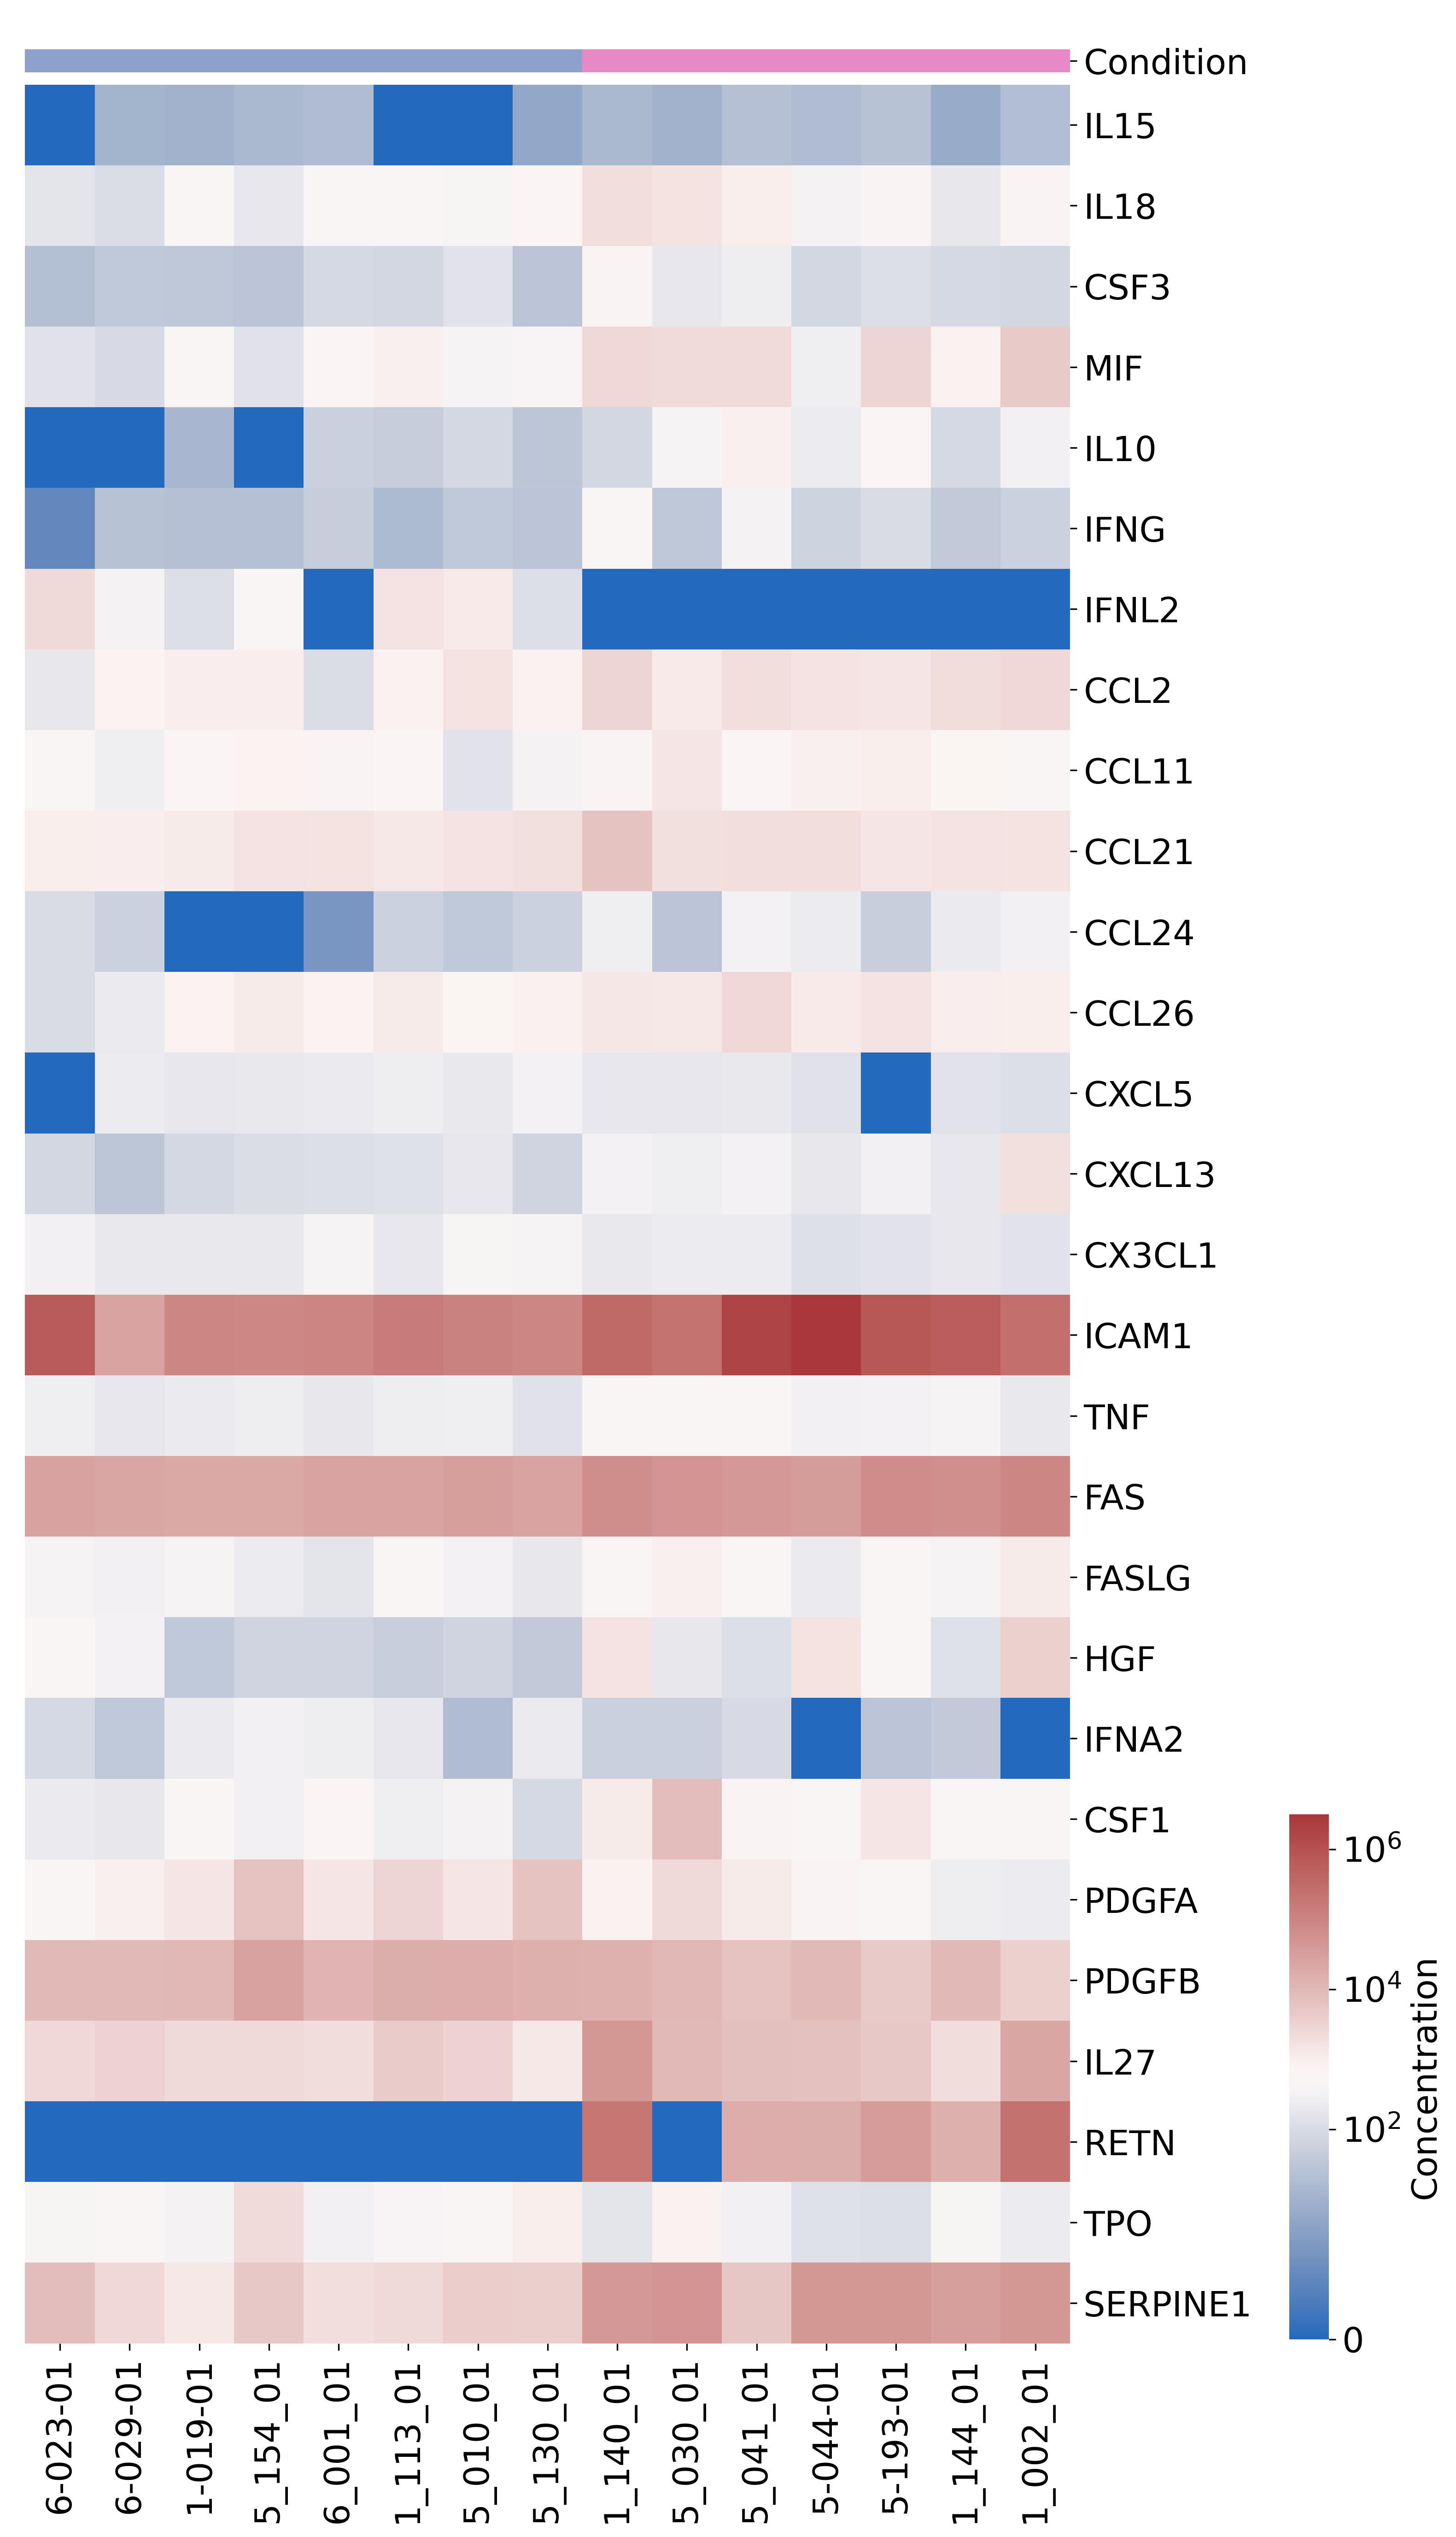

In [52]:
'''
new sig_cytos: IL15, IL18,
deleted sig_cytos: CXCL10, IL6,
'''

genes_show = [
    # proinflamation
    'IL15', 'IL18', 'CSF3', 'MIF', 'IL10', 'IFNG', 'IFNL2',
    # anti-inflammatory cytokines
    # Immunoregulatory cytokines
    
    # Cell migration
     'CCL2','CCL11','CCL21','CCL24','CCL26','CXCL5','CXCL13', 'CX3CL1', 'ICAM1', 
    # TNF family members
    'TNF', 'FAS', 'FASLG',
    # Angiogenic and fibrogenic factors
    'HGF',

    # 
    'IFNA2', 
    'CSF1', 'PDGFA', 'PDGFB',
    'IL27',
    'RETN', 'TPO',
    'SERPINE1'
]

colors=sns.color_palette('Set2', 4)
cmap_dic = {'H': colors[0], 'D': colors[2], 'DWS': colors[1], 'SD': colors[3]}
row_colors = res.reset_index().set_index('ID')['Condition'].map(cmap_dic)
U_data = data_show(pair, res, 'pvalue_U', ['D', 'SD'])

heatmap(U_data[genes_show], row_colors, title='new_group_cyto_D_SD_c')

In [8]:
pvalue='pvalue_U'
idx_ks = pair[pair[pvalue] < 0.05].sort_values(['med_pair', 'avg_SD'], ascending=False).index
idx_not = [idx for idx in pair.index if idx not in idx_ks]
idx_ks_rest = pair.loc[idx_not].sort_values(['med_pair', 'avg_SD'], ascending=False).index
new_idx = idx_ks.tolist() + idx_ks_rest.tolist()
res = res[new_idx]

In [9]:
res_nml = pd.DataFrame(res.values / res.values.max(axis=0),
                       index=res.index,
                       columns= res.columns
)

<ipython-input-9-f37a71de6643>:1: RuntimeWarning: invalid value encountered in true_divide
  res_nml = pd.DataFrame(res.values / res.values.max(axis=0),


In [23]:
res_ref = pd.read_excel('/home/yike/phd/dengue/docs/nature_immunology_review/20230831_accepted/Source_data/Fig. 5e.xlsx')

res_nml[res_ref.loc[1].tolist()[2:]].to_csv('/home/yike/phd/dengue/docs/nature_immunology_review/20230831_accepted/Source_data/Fig. 5e.tsv', sep='\t')

<ipython-input-56-5206ab74c005>:25: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  g.fig.tight_layout()


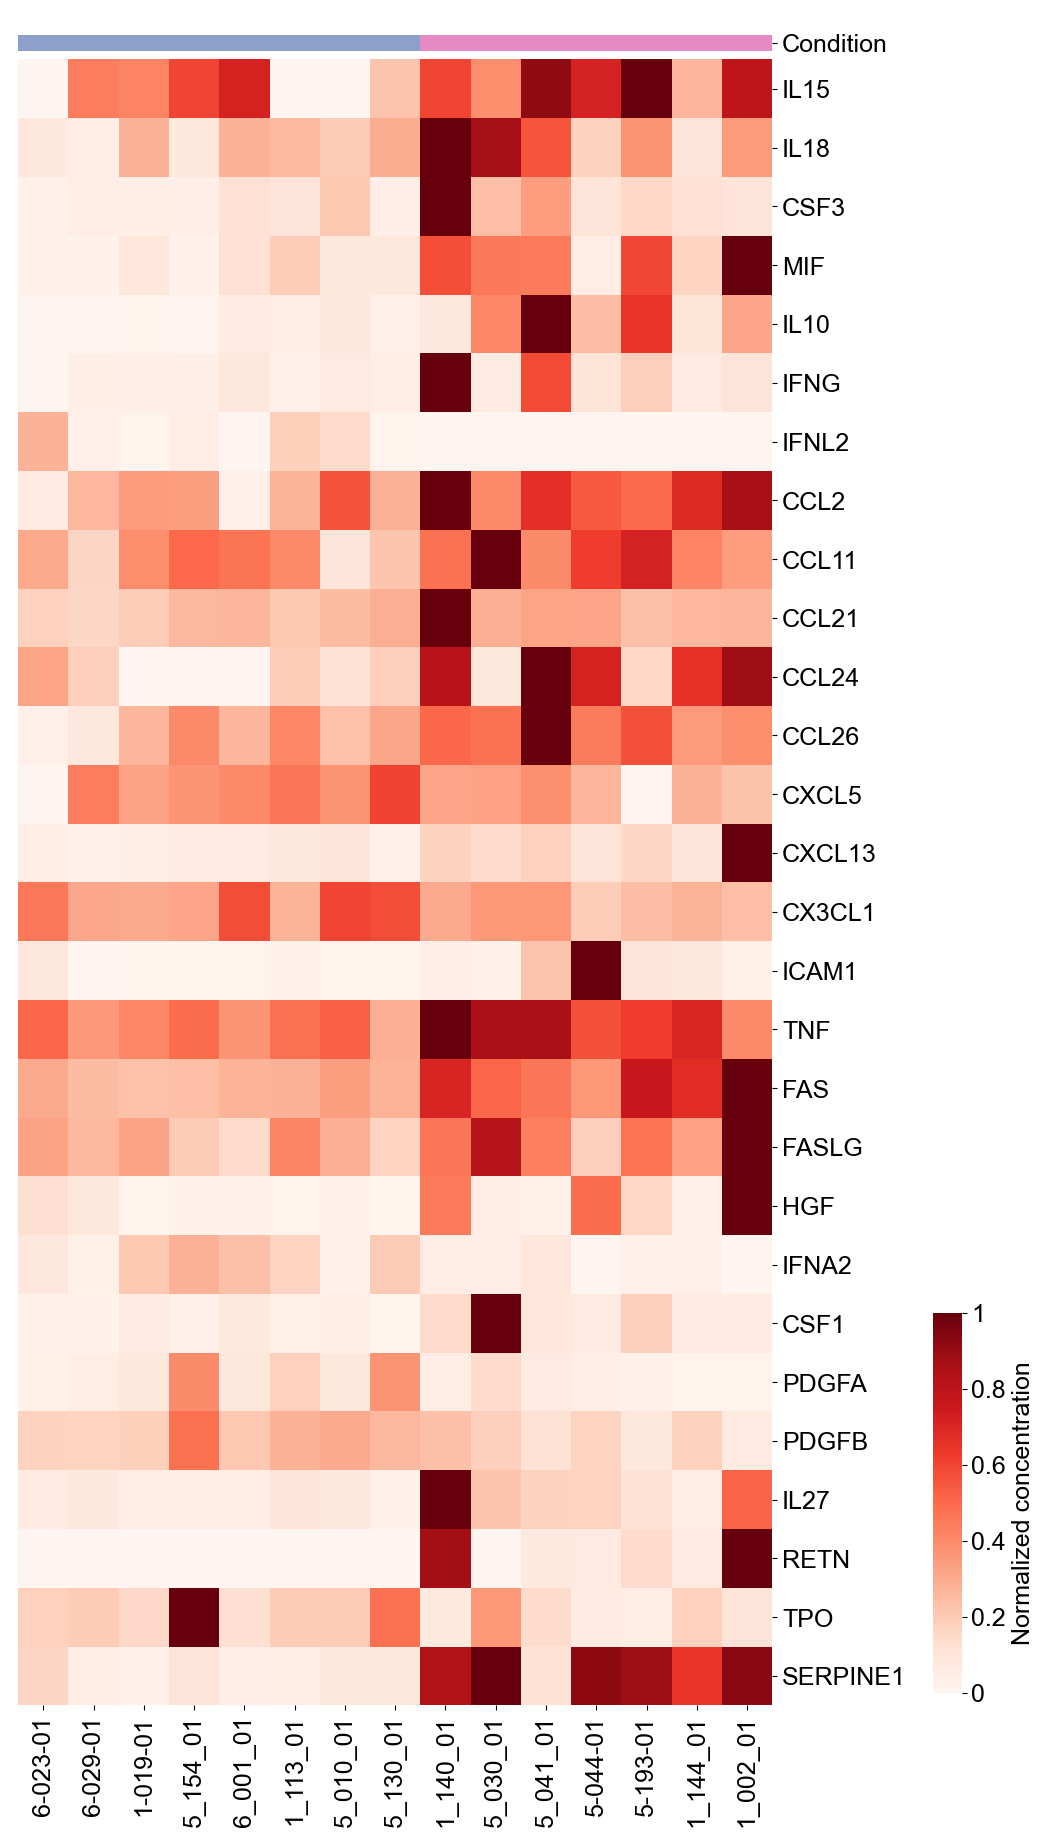

In [56]:
title = 'SD_D_cyto'
res_data = res_nml.loc[['D', 'SD']][genes_show].copy()
res_data = res_data.reset_index().drop('Condition', axis=1).set_index('ID')

colors=sns.color_palette('Set2', 4)
cmap_dic = {'H': colors[0], 'D': colors[2], 'DWS': colors[1], 'SD': colors[3]}
row_colors = res.reset_index().set_index('ID')['Condition'].map(cmap_dic)

rcParams['font.size']=18
rcParams['pdf.fonttype'] = 42
rcParams['font.sans-serif'] = "Arial"
rcParams['figure.dpi'] = 100

cmap = sns.color_palette("Reds", as_cmap=True) # 'vlag', 'Greys'

g = sns.clustermap(res_data.T, col_colors=row_colors, col_cluster=False, row_cluster=False,
                   figsize=[2 + 0.5 * res_data.shape[0], 5 + 0.5 * res_data.shape[1]], cmap=cmap, 
                   cbar_pos=(1, 0.1, .03, .2), vmin=0, vmax=1,
                   dendrogram_ratio=0.01, colors_ratio=0.01,
                   cbar_kws={'label':'Normalized concentration', 'shrink': 0.1,
                             'ticks':[0, 0.2, 0.4, 0.6, 0.8, 1],})

g.ax_heatmap.set_xlabel(None)
g.ax_cbar.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
g.fig.tight_layout()

g.fig.savefig(save_figures + 'heatmap_normalized_' + title + '.png', bbox_inches='tight')
g.fig.savefig(save_figures + 'heatmap_normalized_' + title + '.pdf', bbox_inches='tight')

In [61]:
# plot violin plots for significant cytokines
def cyto_violin(res, cyto):
    rcParams['font.size'] = 18
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"
    rcParams['figure.dpi'] = 300
    
    cmap = sns.color_palette('Set2', 4)
    palette = [cmap[0], cmap[1], cmap[3]]
#     res = res.set_index(['Condition', 'ID'])
    res_c = res[[cyto]].loc[['H', 'D', 'SDp']].reset_index()
    fig, ax = plt.subplots(figsize=(3, 4))
    ax = sns.violinplot(data=res_c, x='Condition', y=cyto, scale='width', inner='point', palette=palette,
                       bw=0.5, cut=0, saturation=0.8)
    ax.set_ylabel('Concentration (pg/mL)')
    yticks = ax.get_yticks().tolist()
    unit = len(str(int(-yticks[0]))) - 1
    yticklabels = [str(int(i/10**unit)) + '×$10^{}$'.format(str(unit)) for i in yticks]
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_title(cyto)
    
    return {'fig': fig, 'ax': ax}

from scipy.stats import gaussian_kde
def cyto_violin_new(res, cyto):
    rcParams['font.size'] = 18
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"
    rcParams['figure.dpi'] = 300
    
    res_c = res[cyto].loc[['H', 'D', 'SDp']]
    
    n = len(str(res_c.max()).split('.')[0]) - 1
    lim = ((res_c.max() // (10**n)) + 1) * 10 ** n

    fig, ax = plt.subplots(figsize=(3, 4))
    cmap = sns.color_palette('Set2', 4)
    palette = [cmap[0], cmap[1], cmap[3]]

    for i, cd, cl in zip(range(3), ['H', 'D', 'SDp'], palette):
        x = res_c.loc[cd].tolist()
        if max(x) == min(x):
            x = np.zeros(len(x))
            x[0] = 0.01
        # This is the key line
        xfit = np.linspace(0, lim, 1000); 
        yfit = gaussian_kde(x)(xfit); 
        yfit *= 0.4 / yfit.max()
        ax.fill_betweenx(xfit, -yfit + i, yfit + i, facecolor=cl, edgecolor='k', alpha=0.6, lw=2)
        ax.scatter([i] * len(x), x, color='k', alpha=0.6, edgecolor=None, s=10)

    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['H', 'D', 'SDp'])

    yticks = ax.get_yticks().tolist()
    unit = len(str(int(-yticks[0]))) - 1
    yticklabels = [str(int(i/10**unit)) + '×$10^{}$'.format(str(unit)) for i in yticks]
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)

    ax.set_ylabel('Concentration (pg/mL)')
    
    ax.set_title(cyto)
    
    return {'fig': fig, 'ax': ax}


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

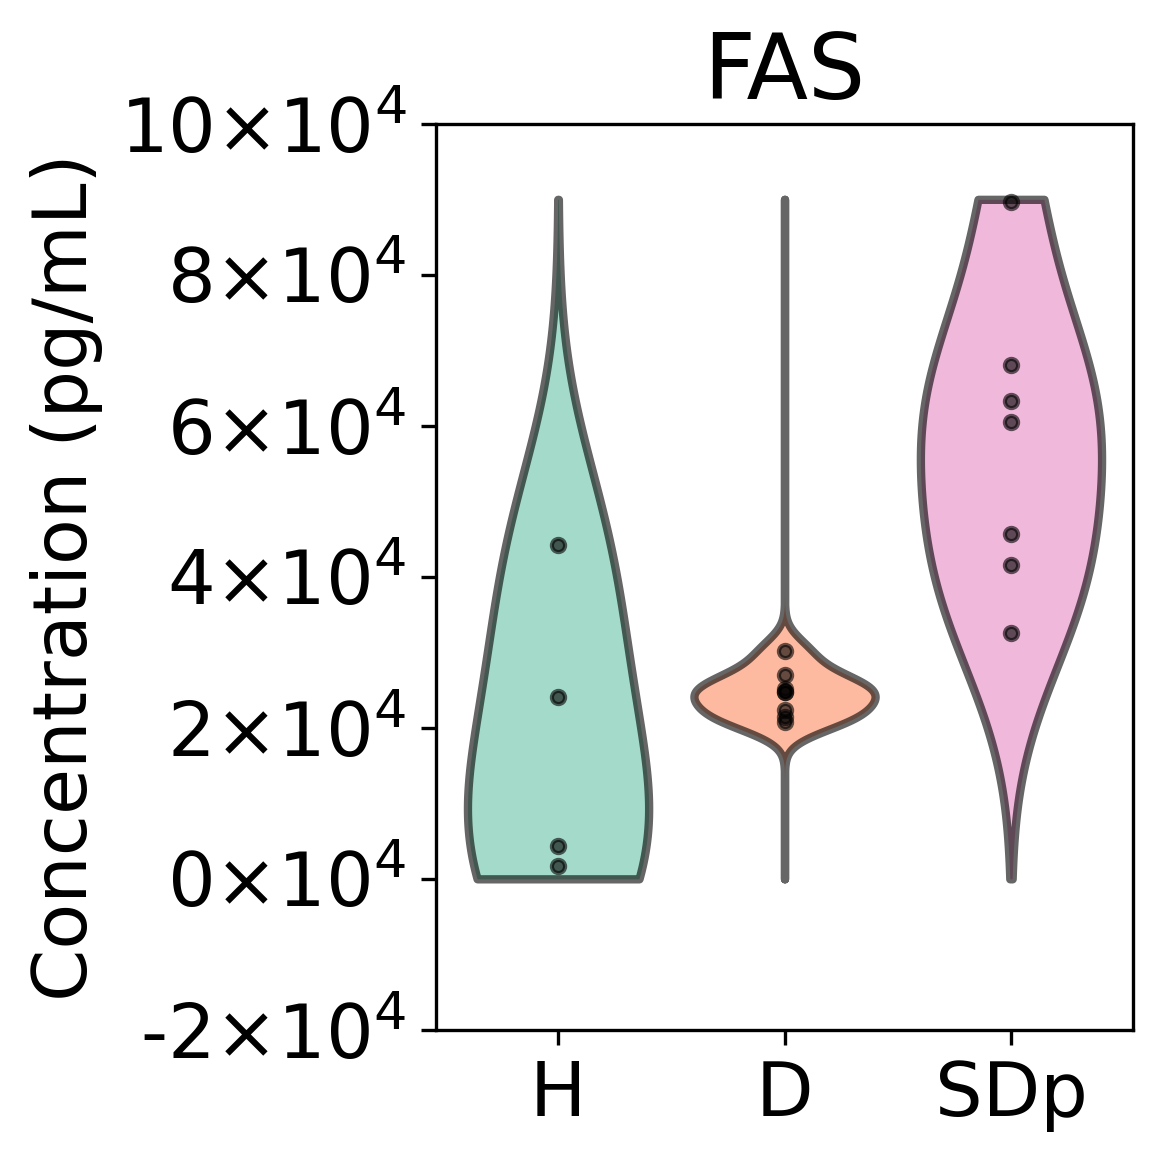

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

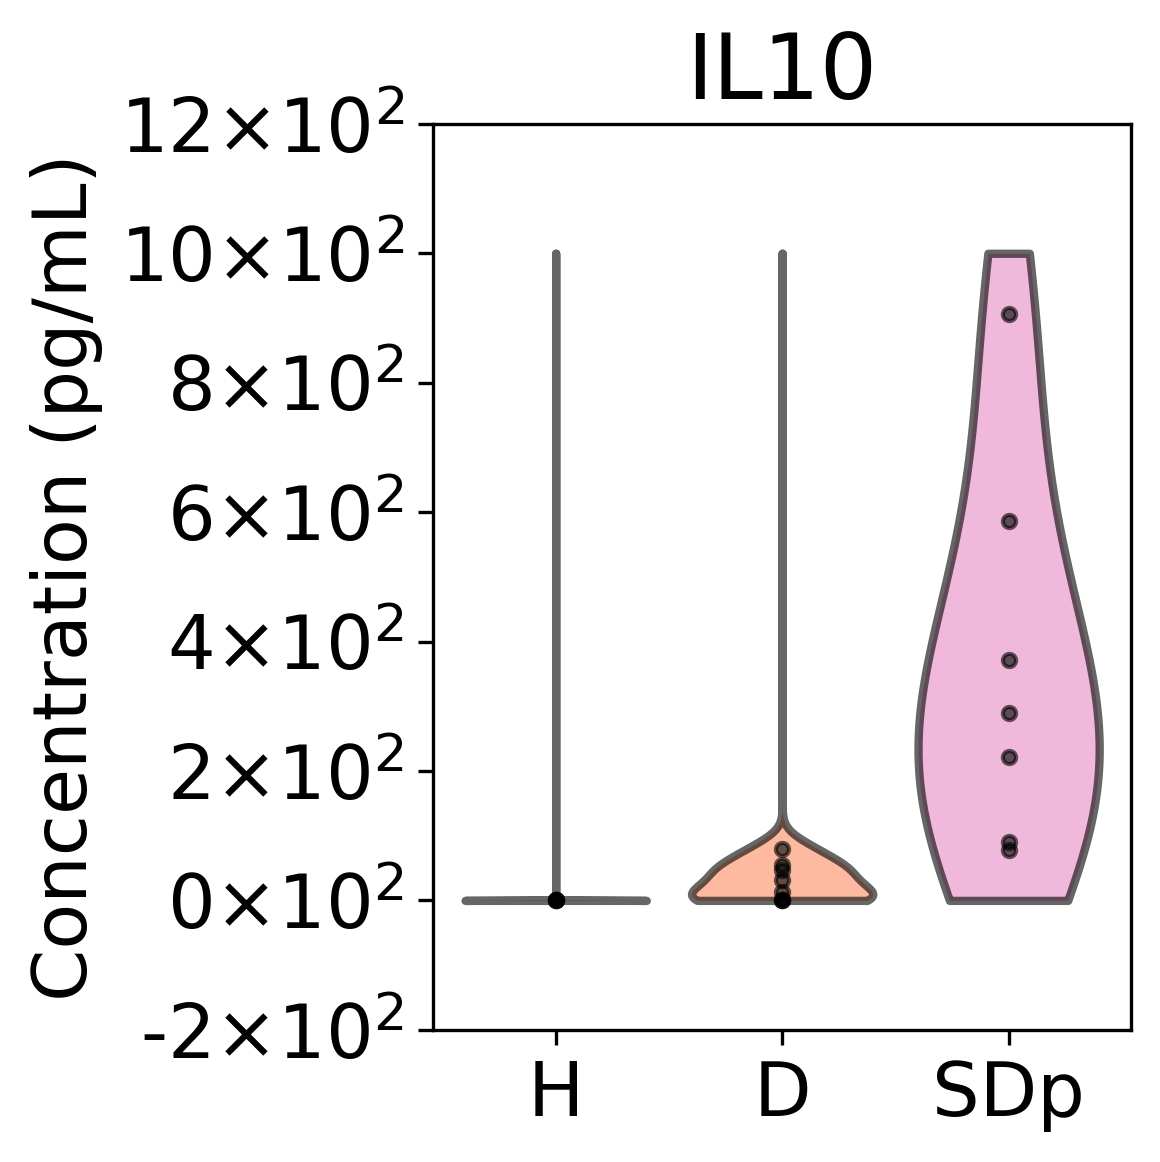

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

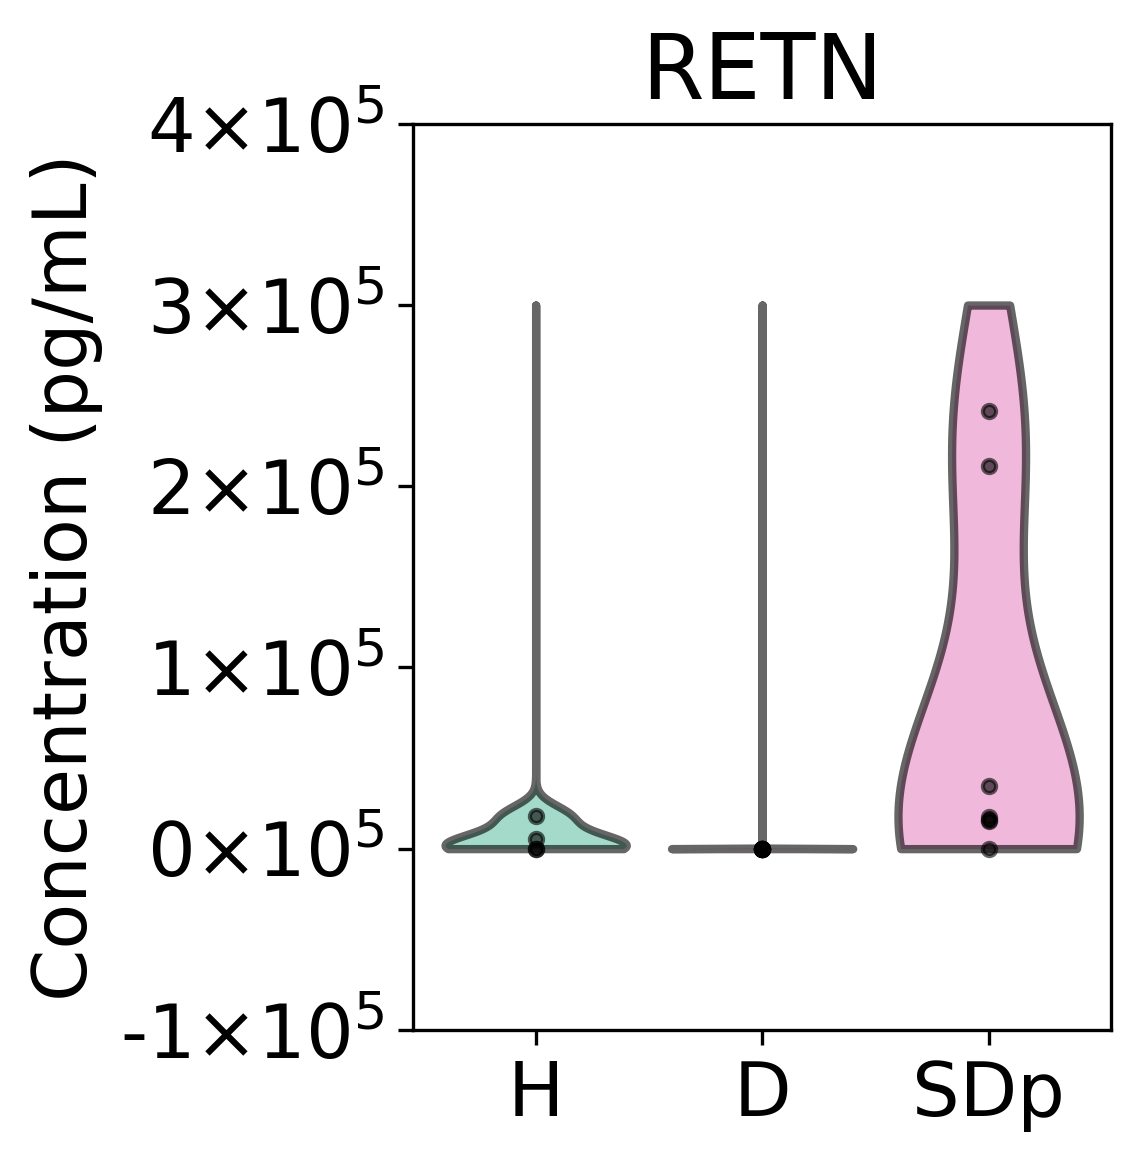

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

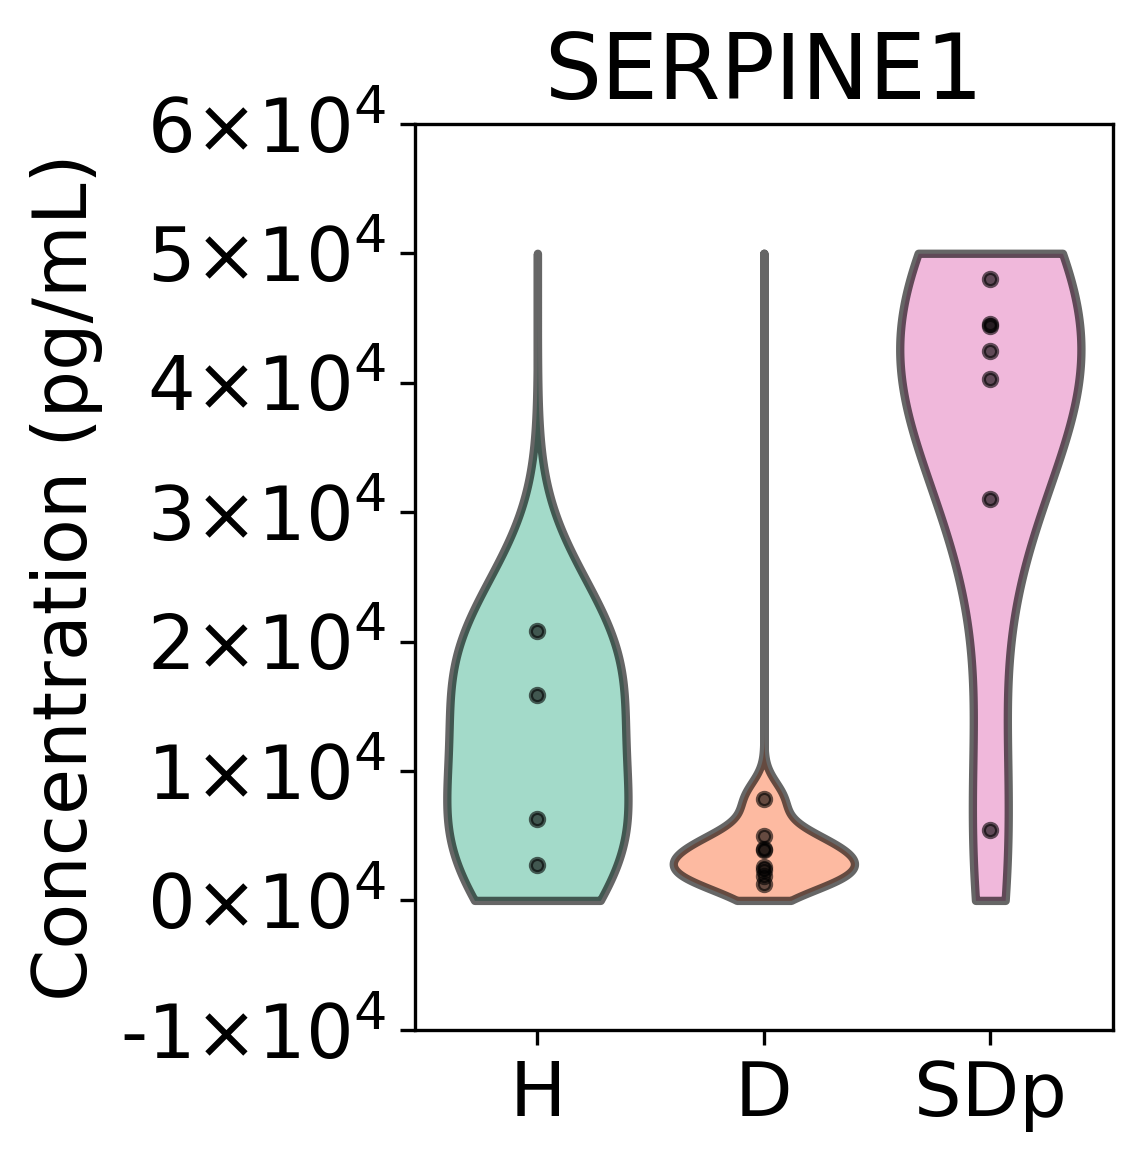

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

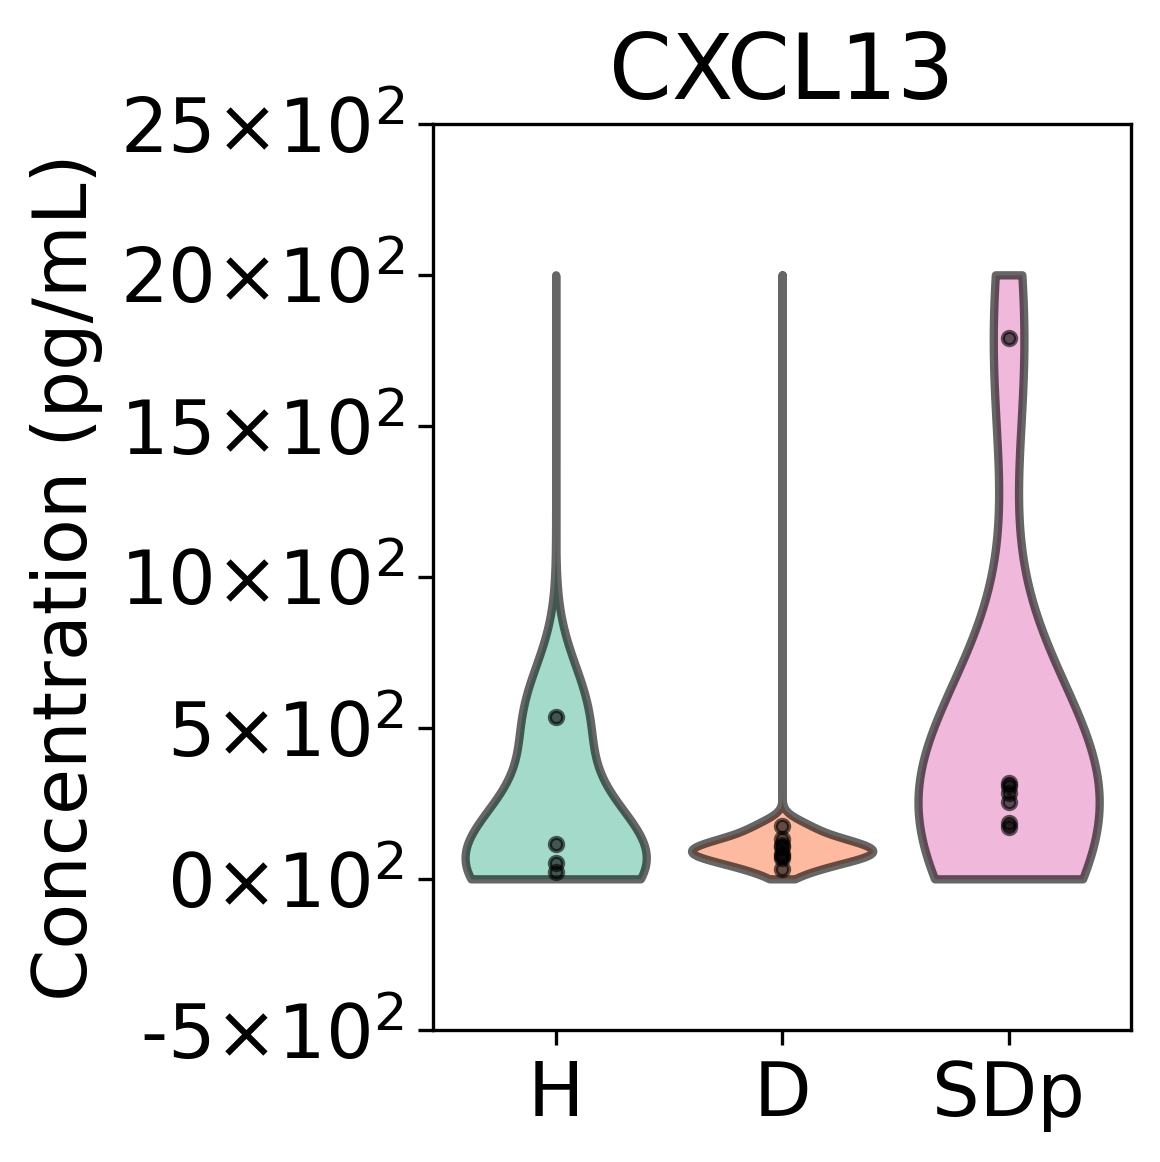

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

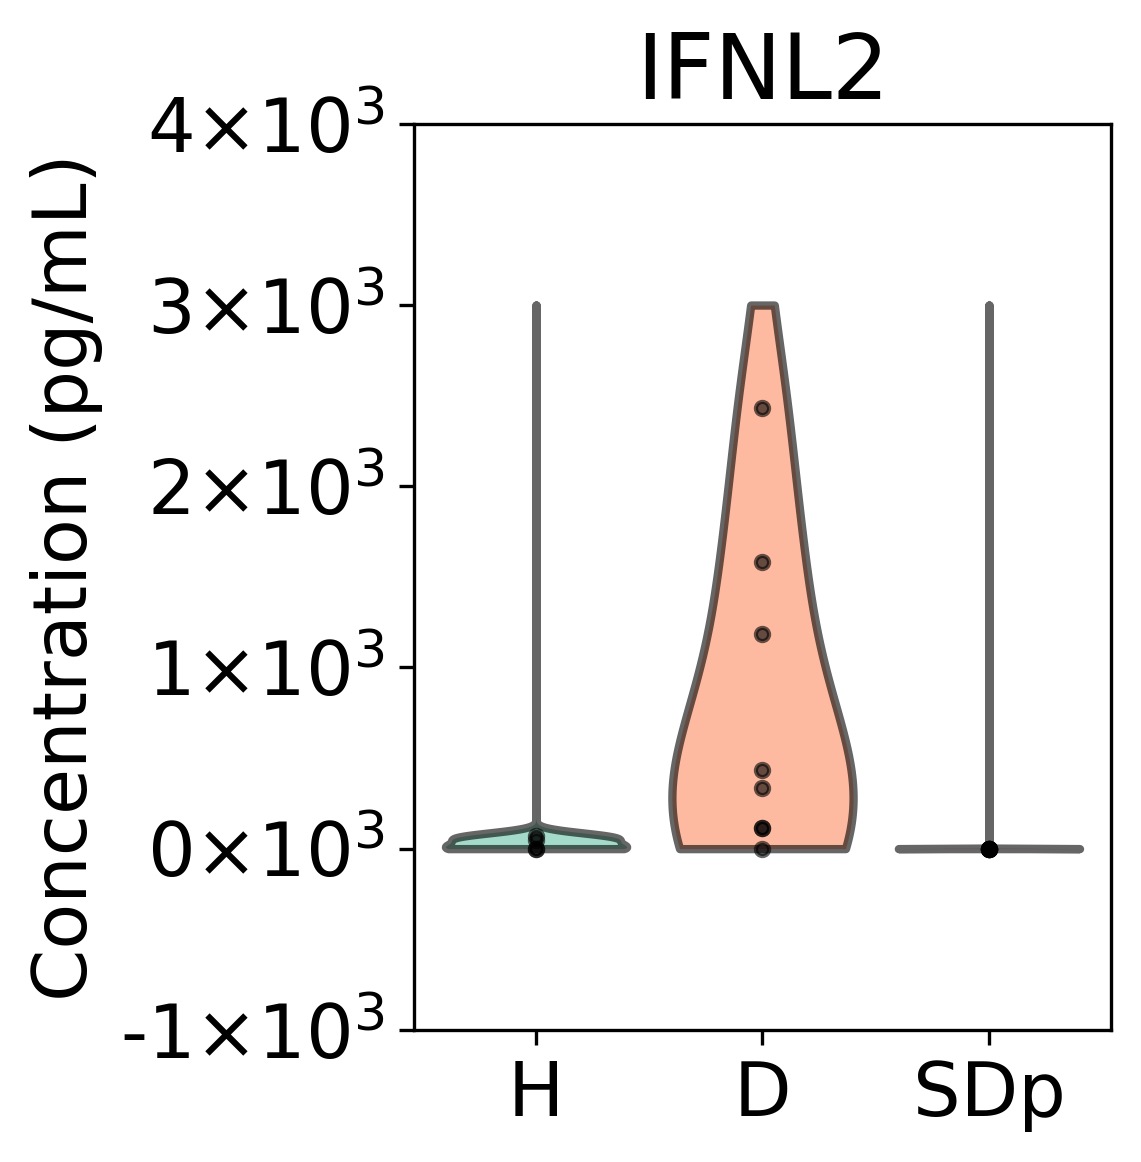

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

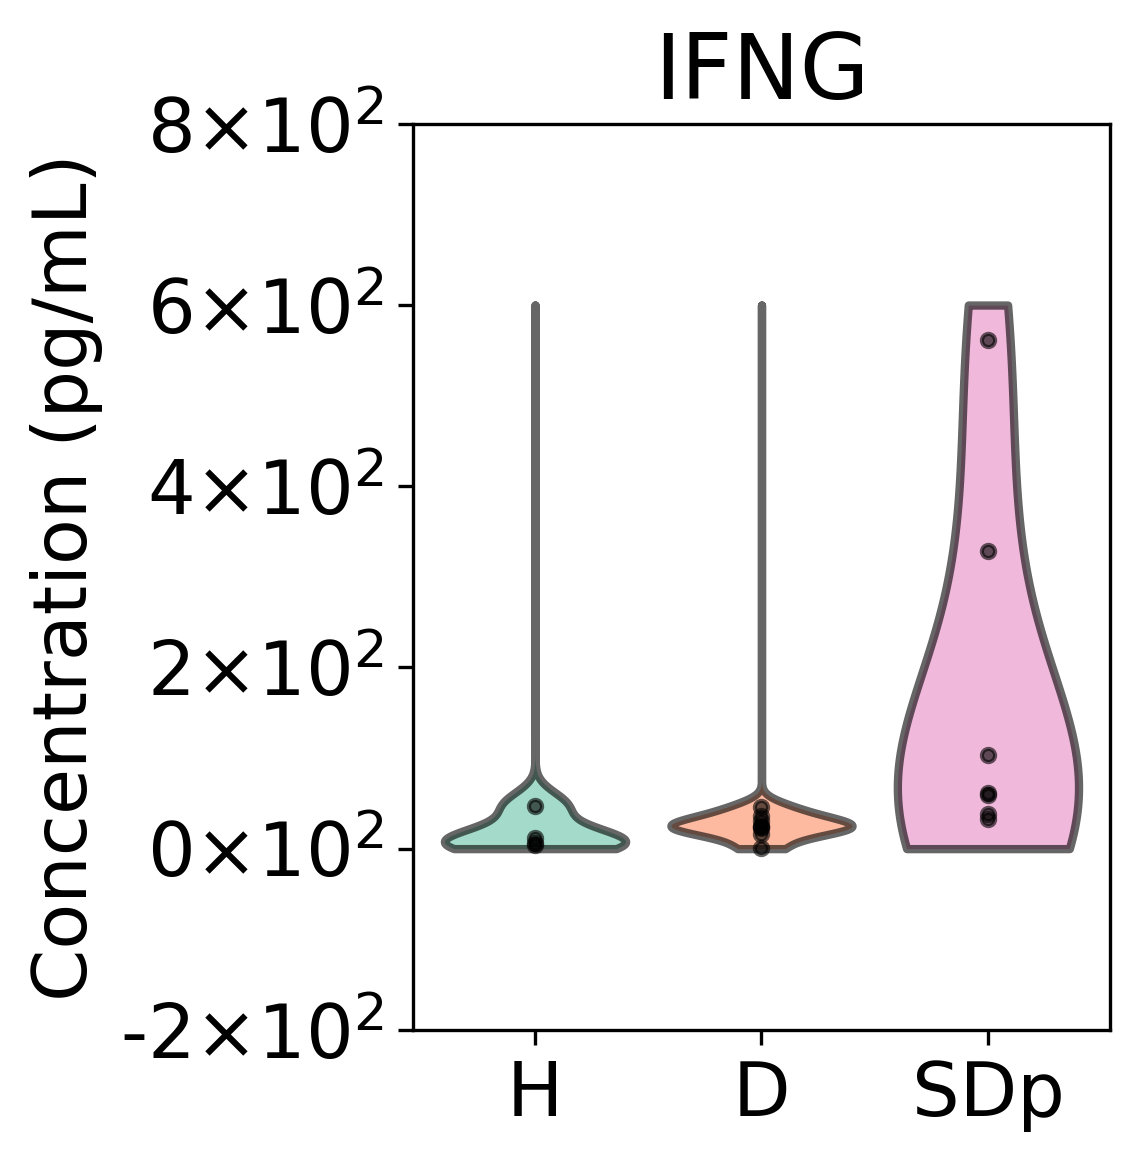

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

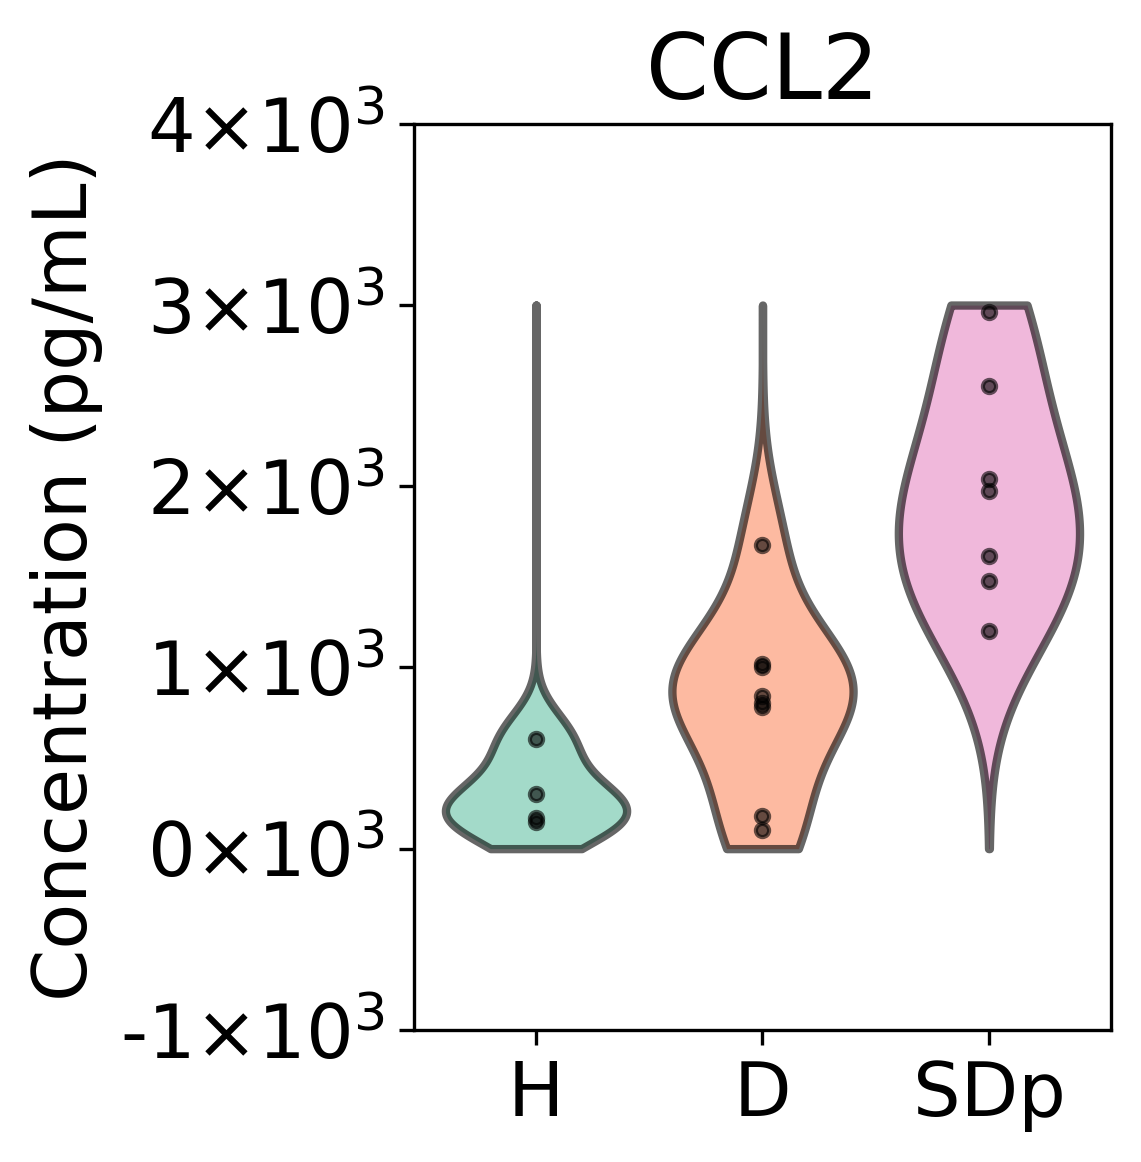

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

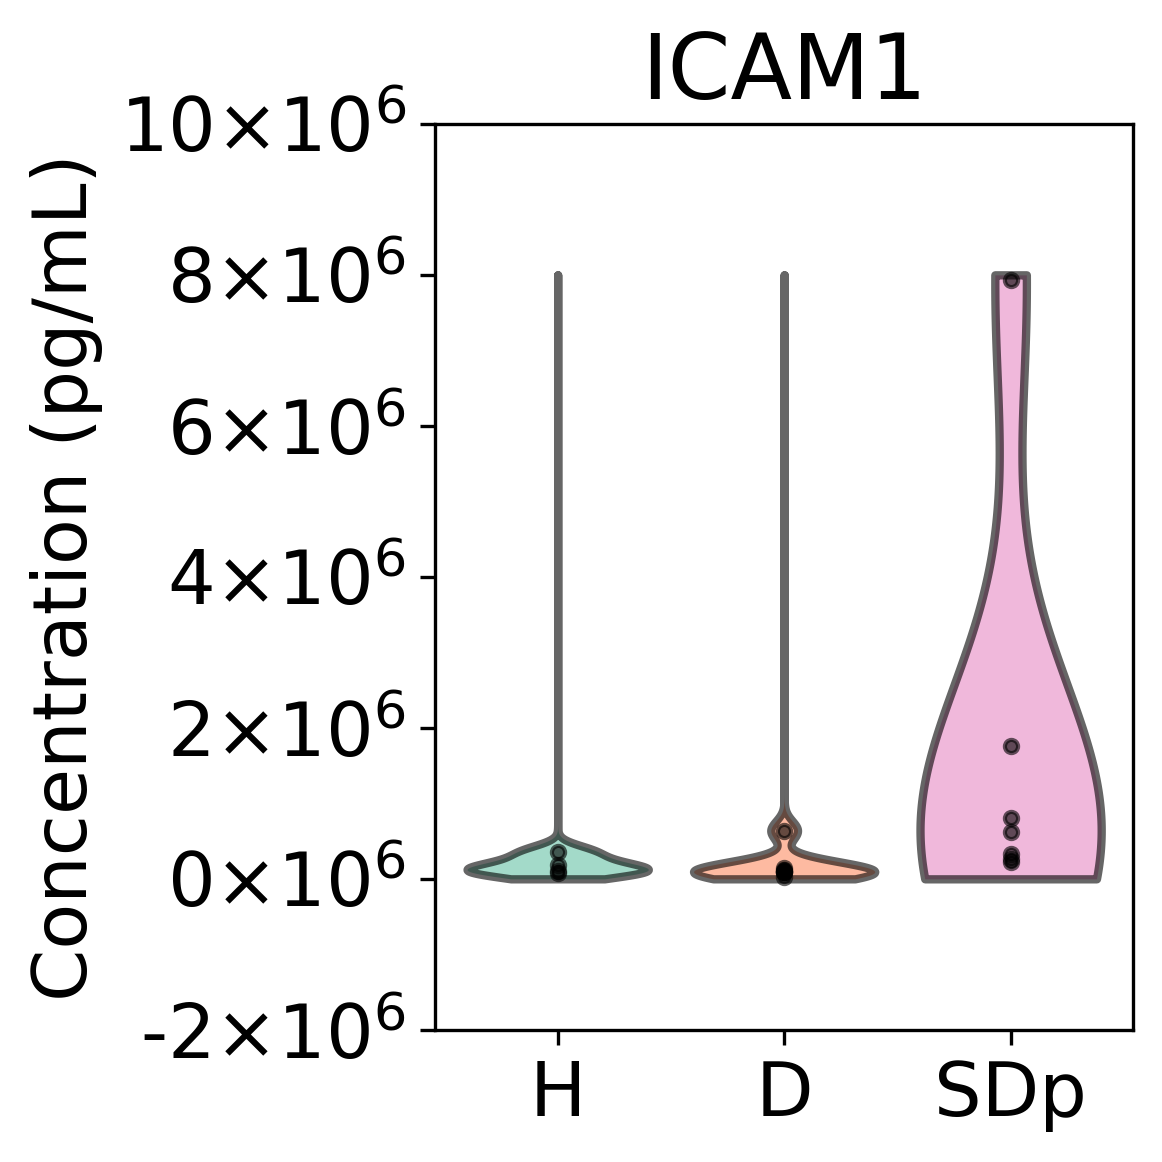

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

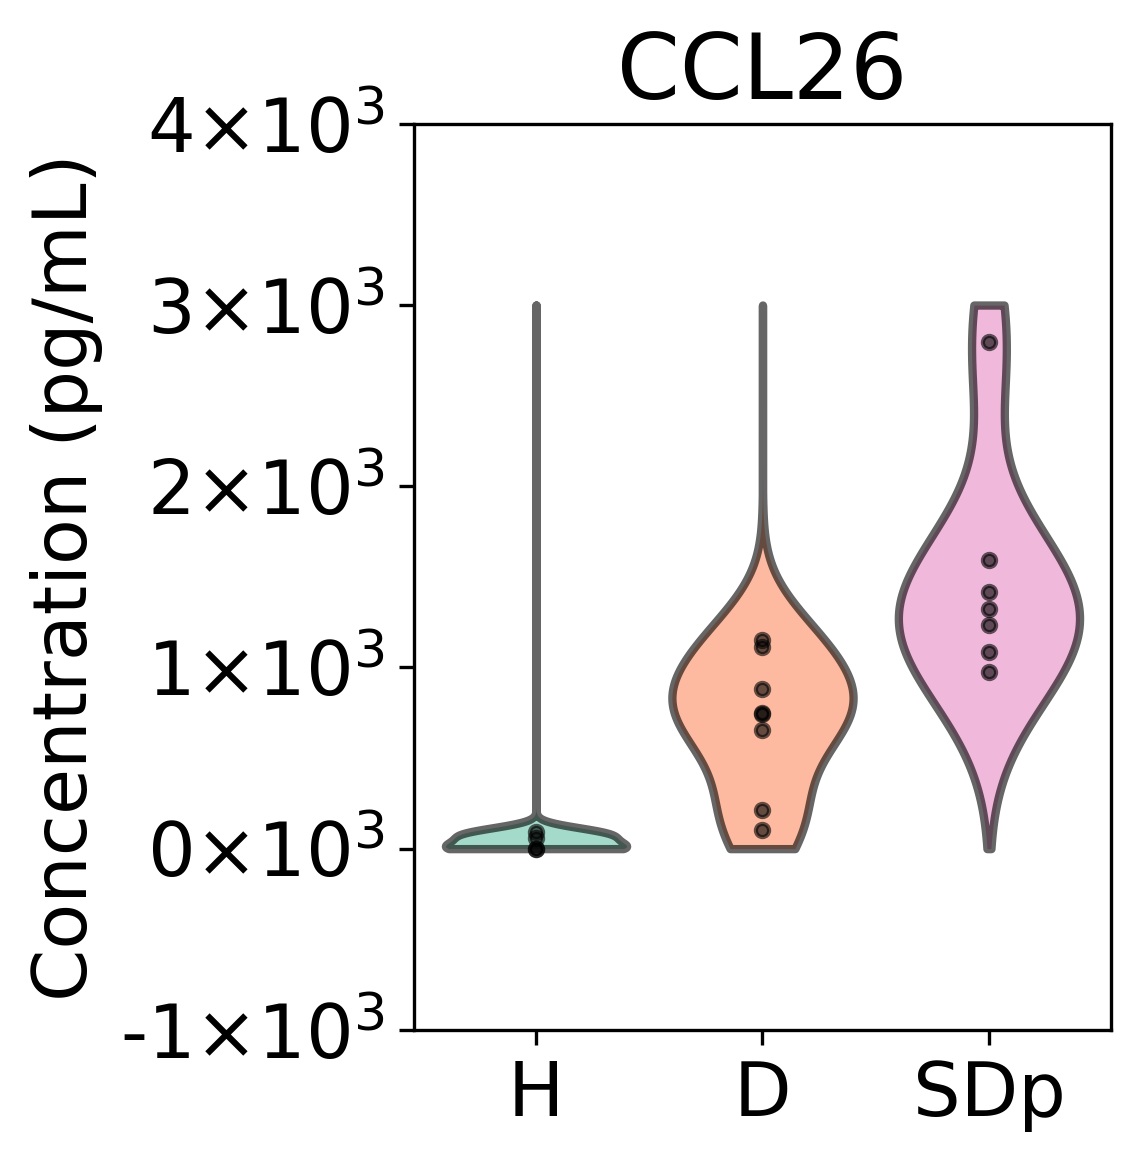

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

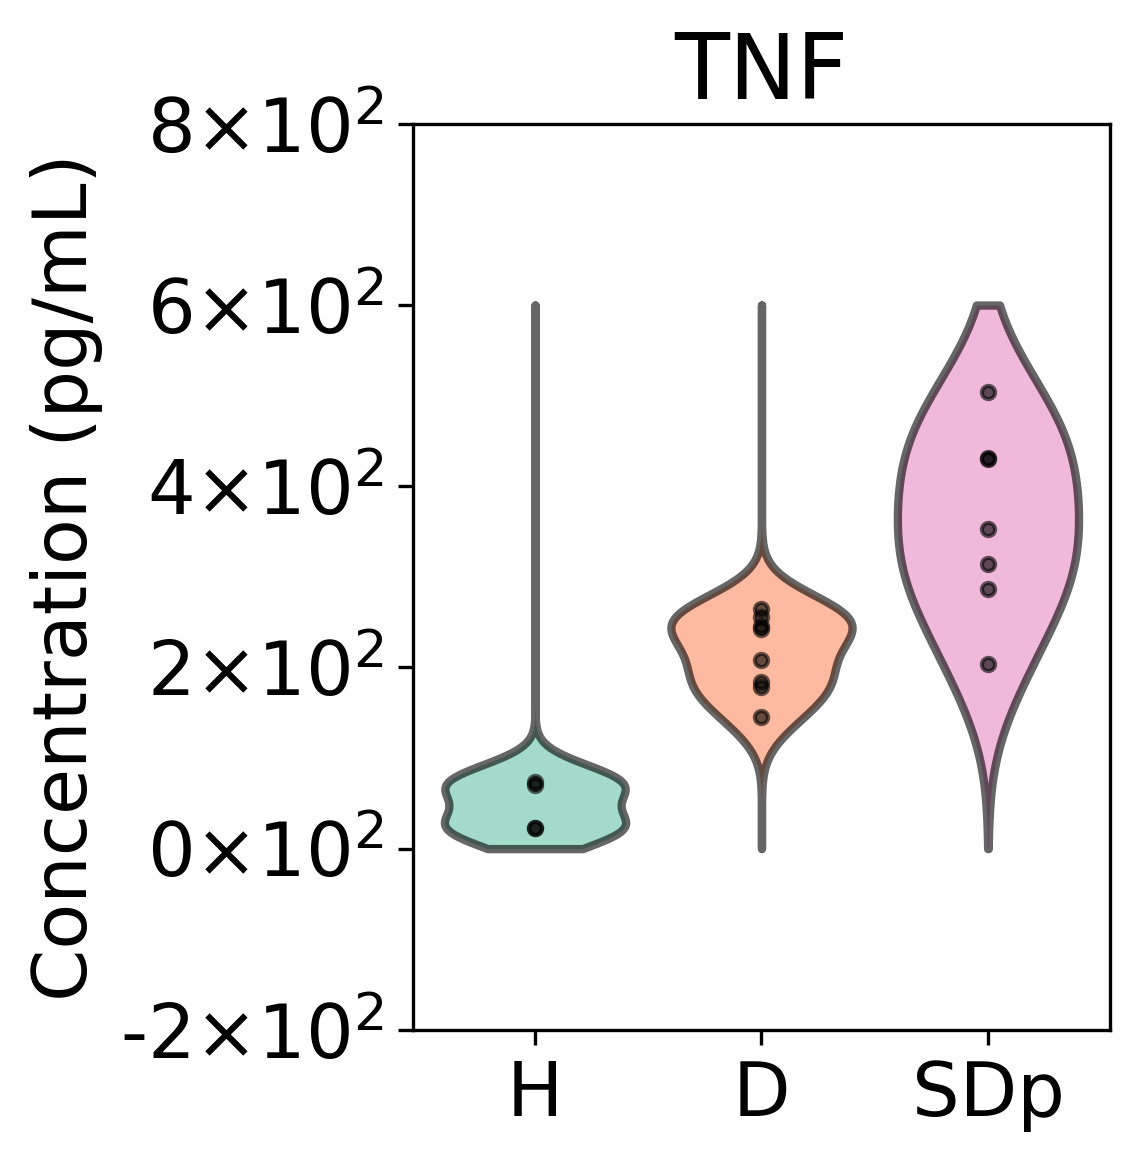

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

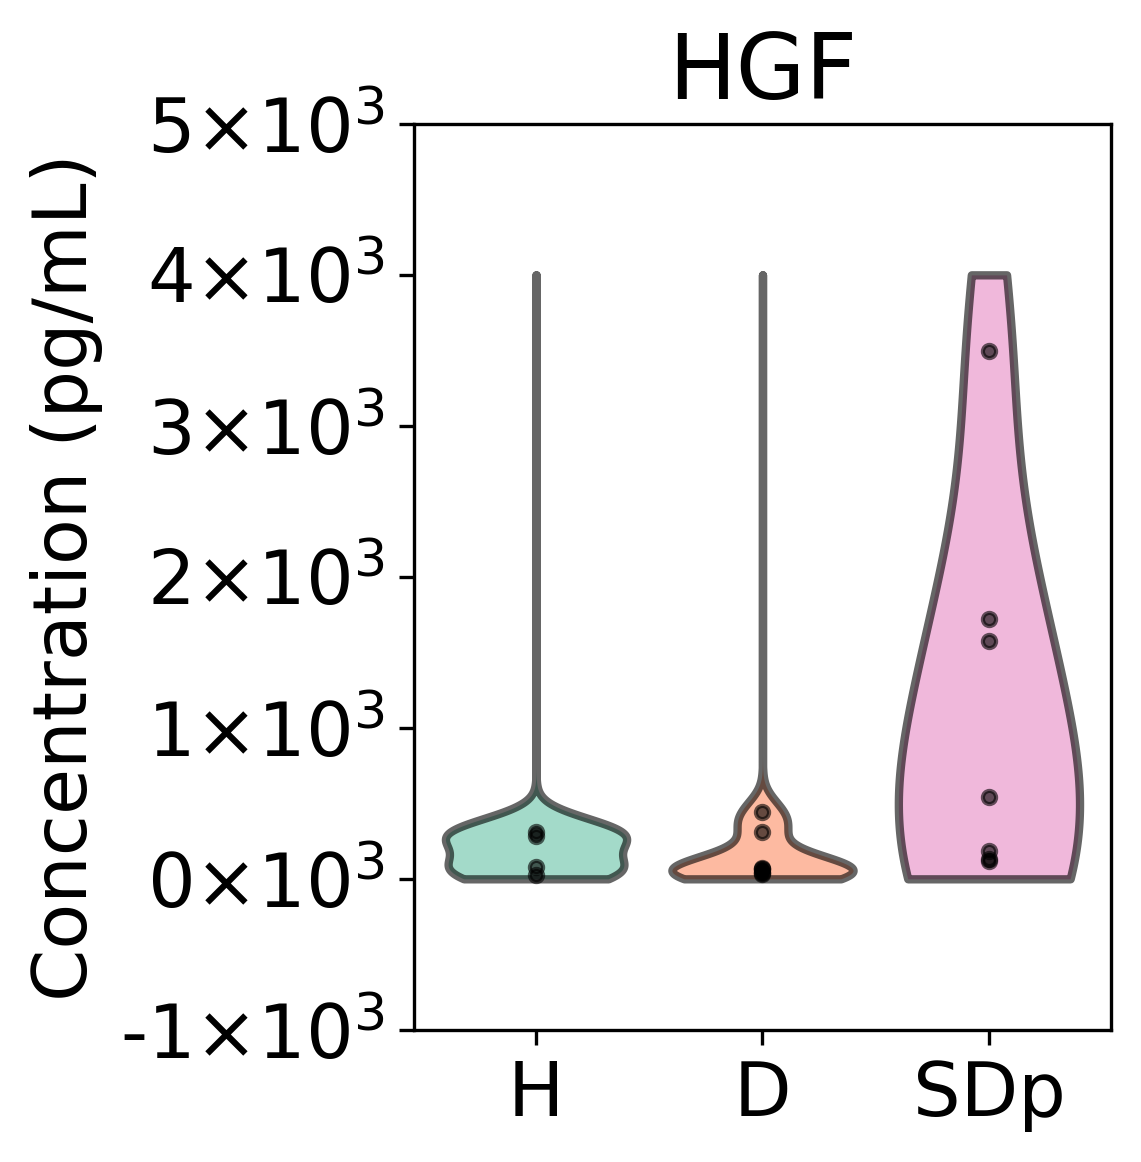

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

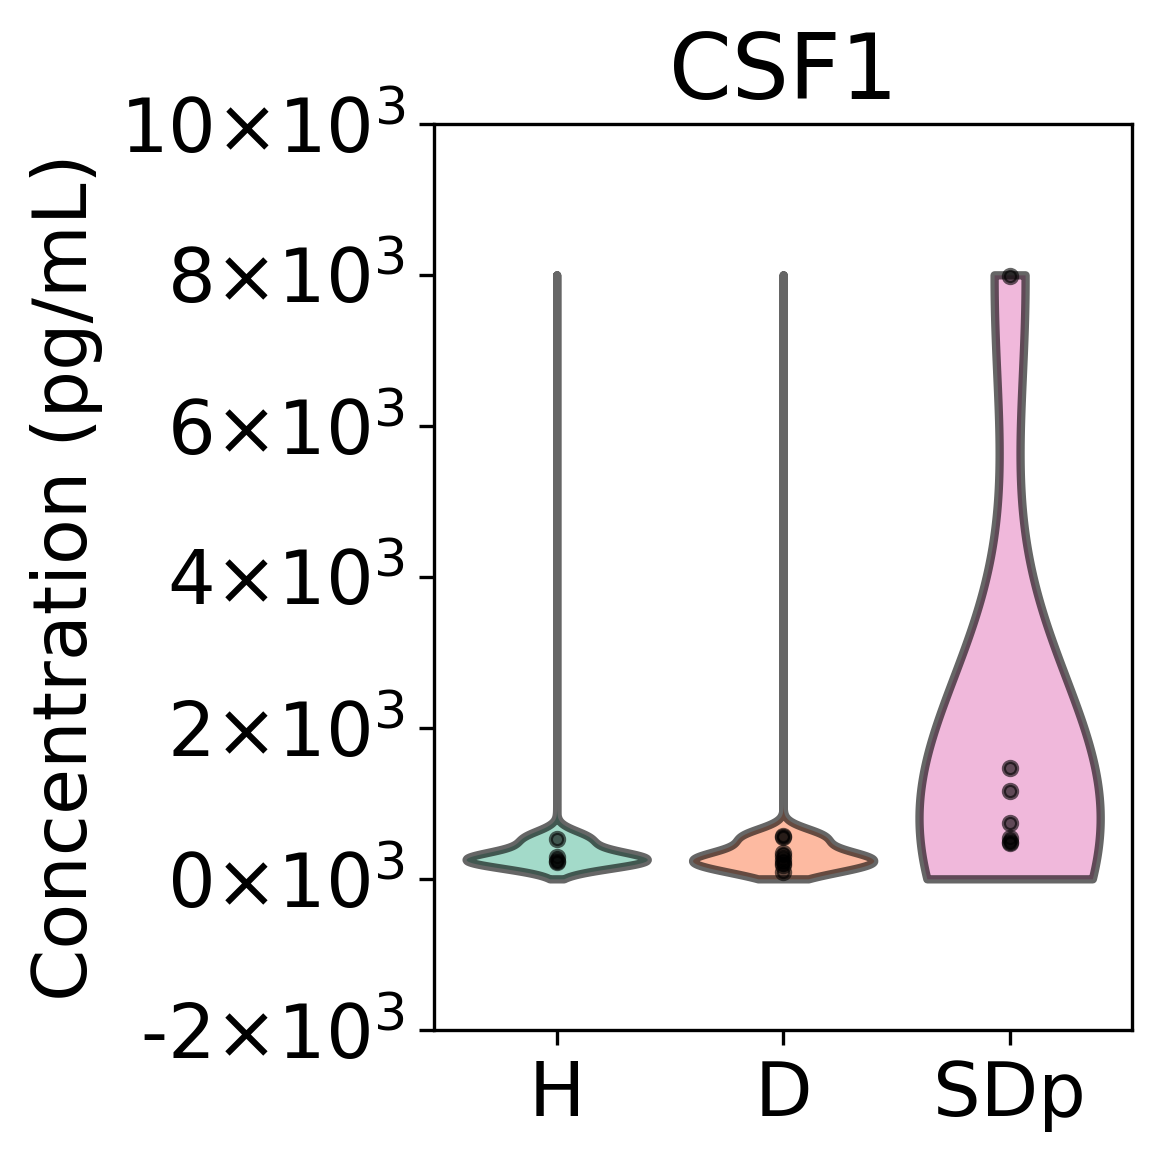

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

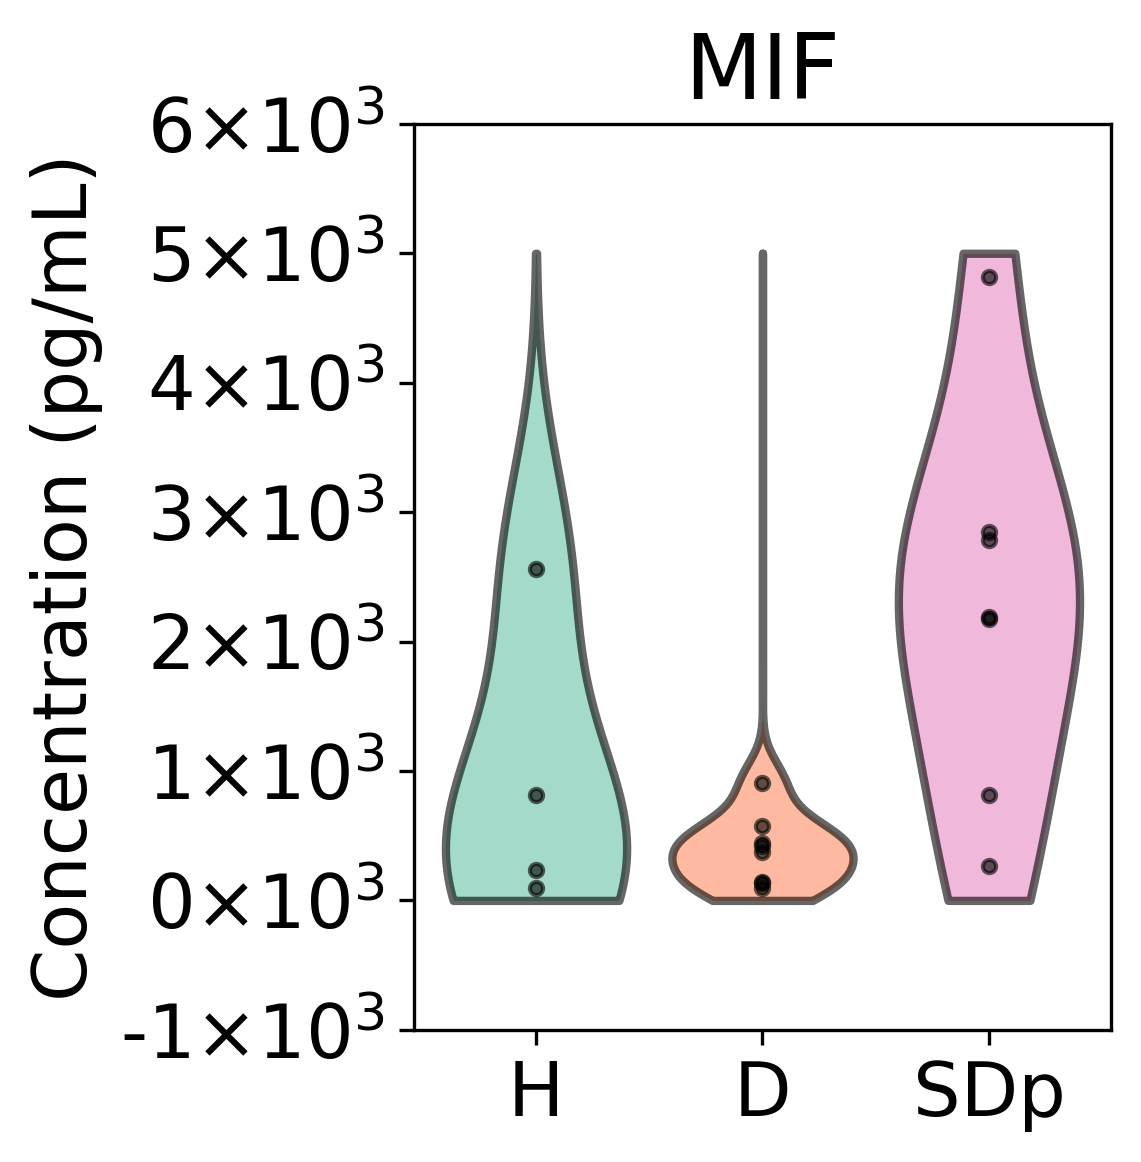

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

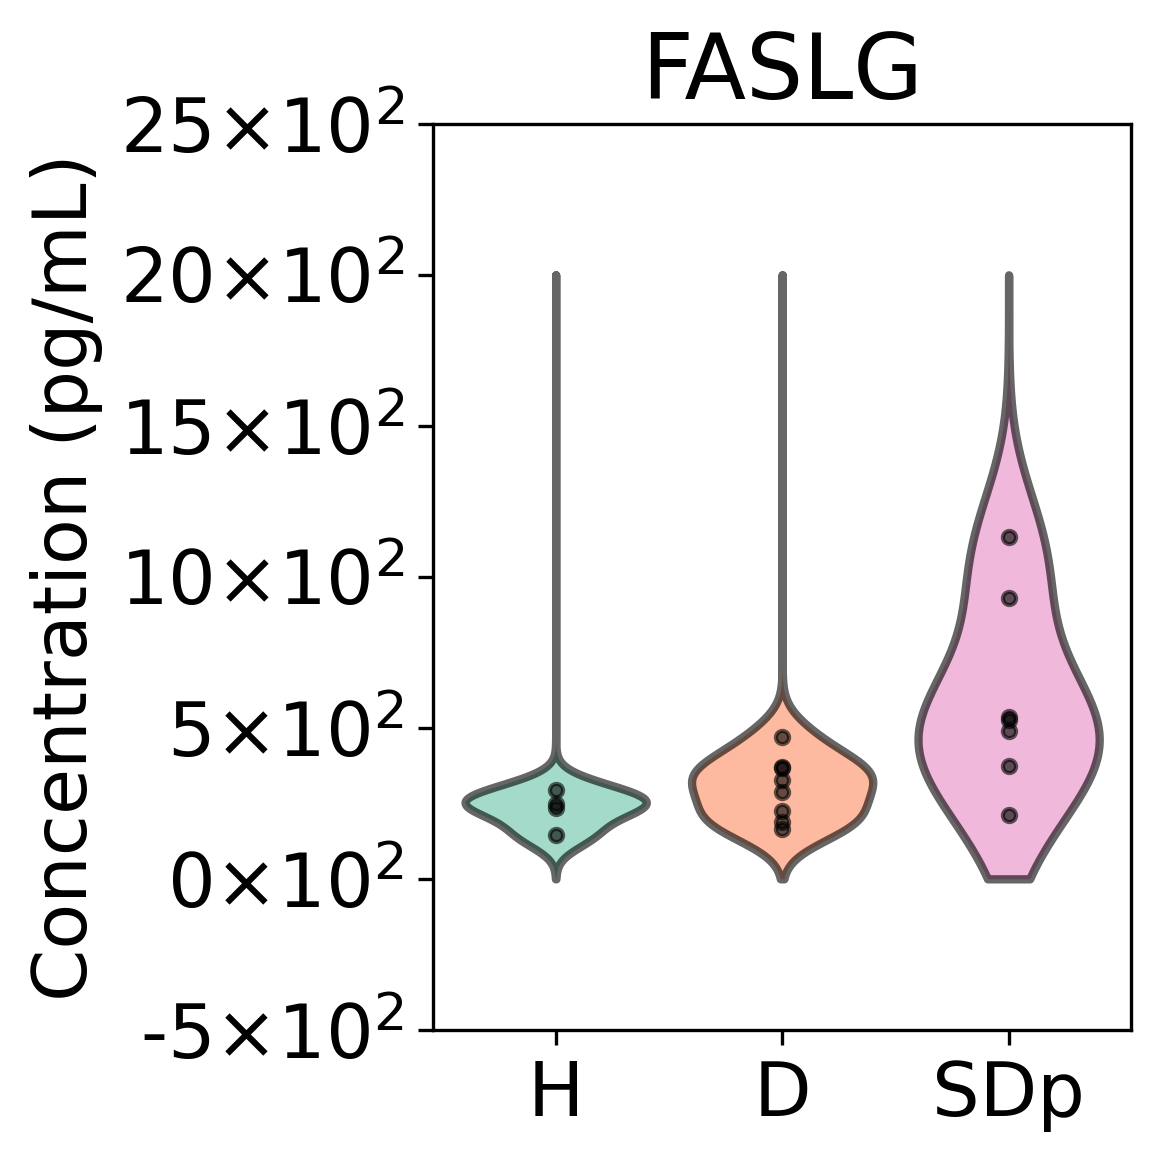

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

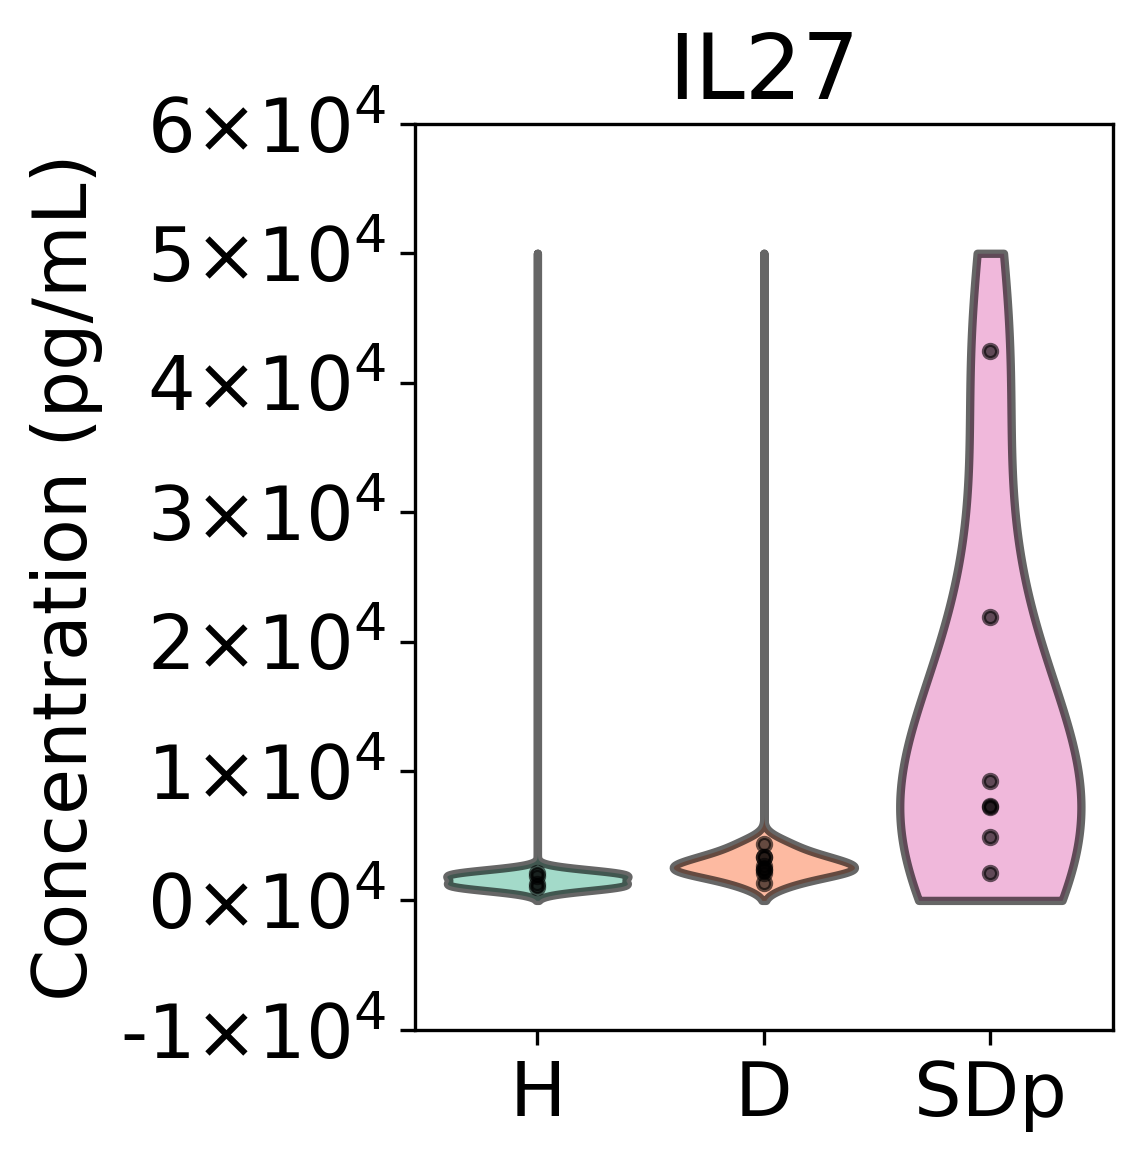

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

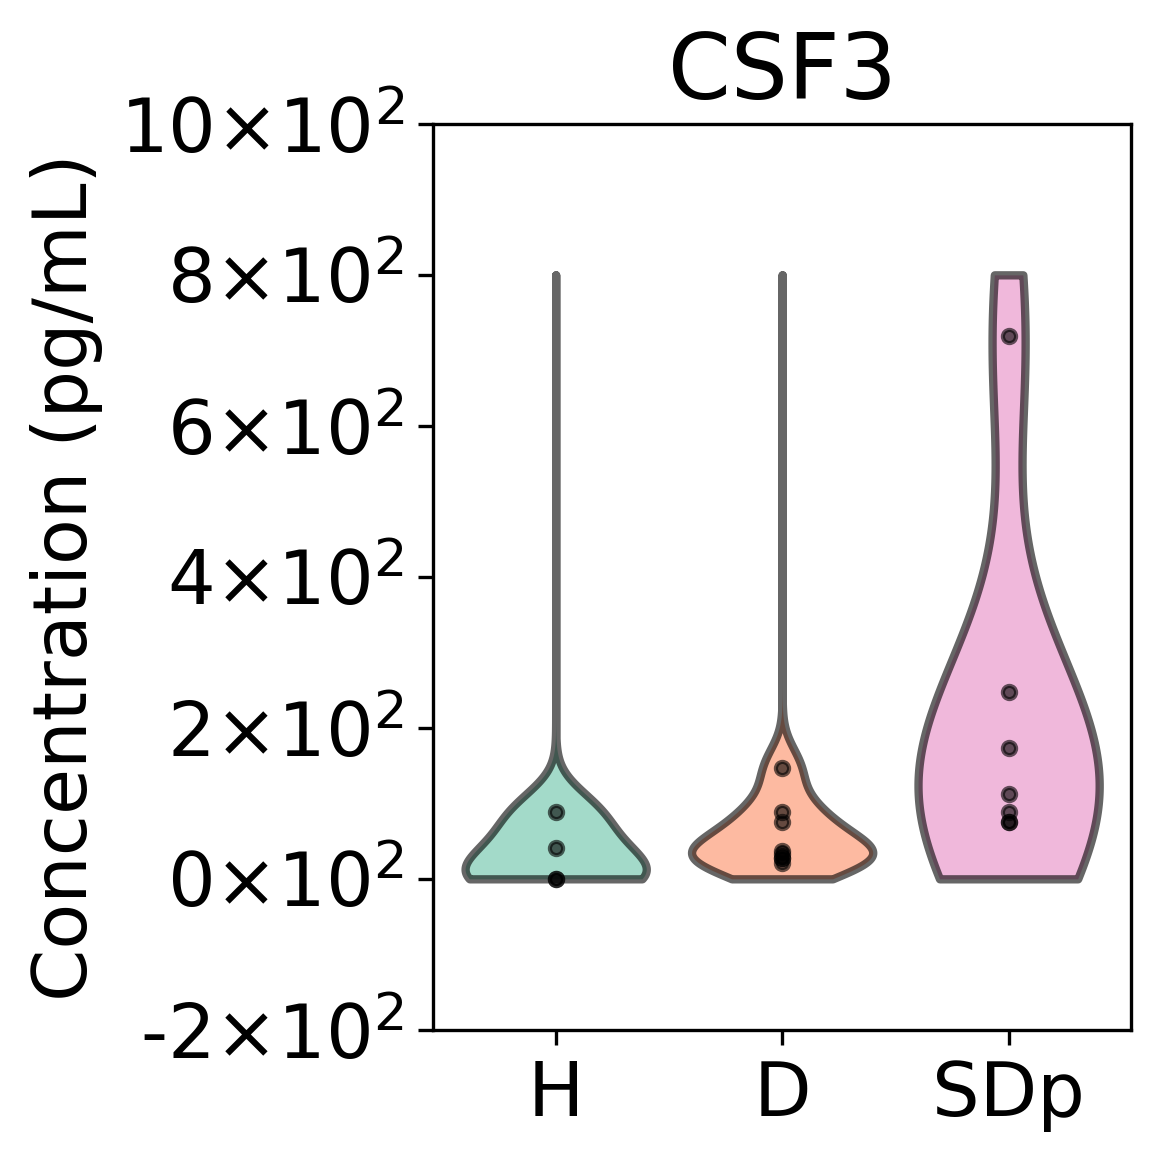

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

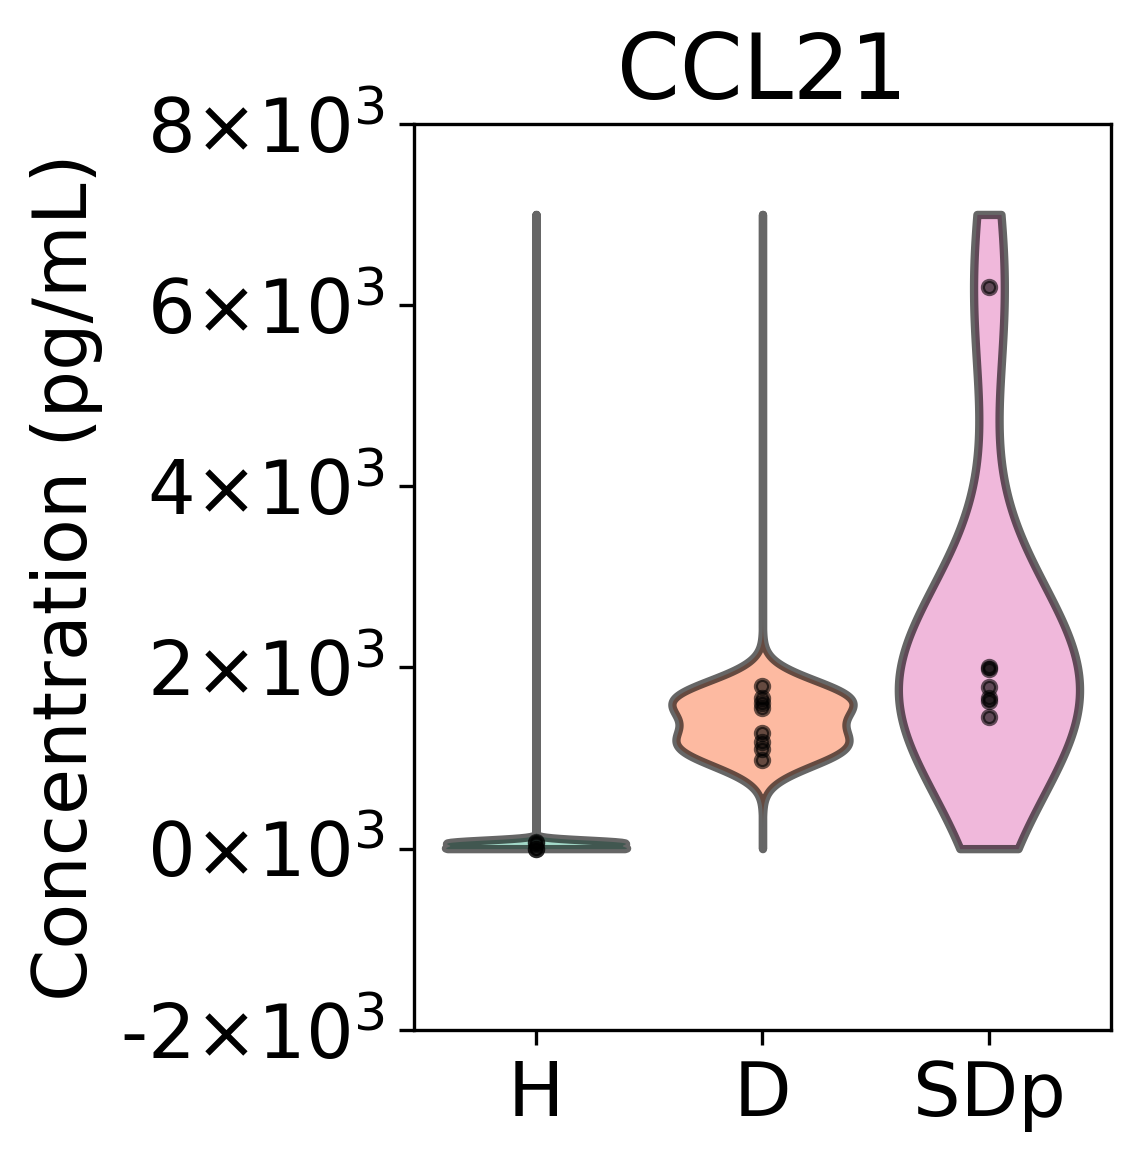

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

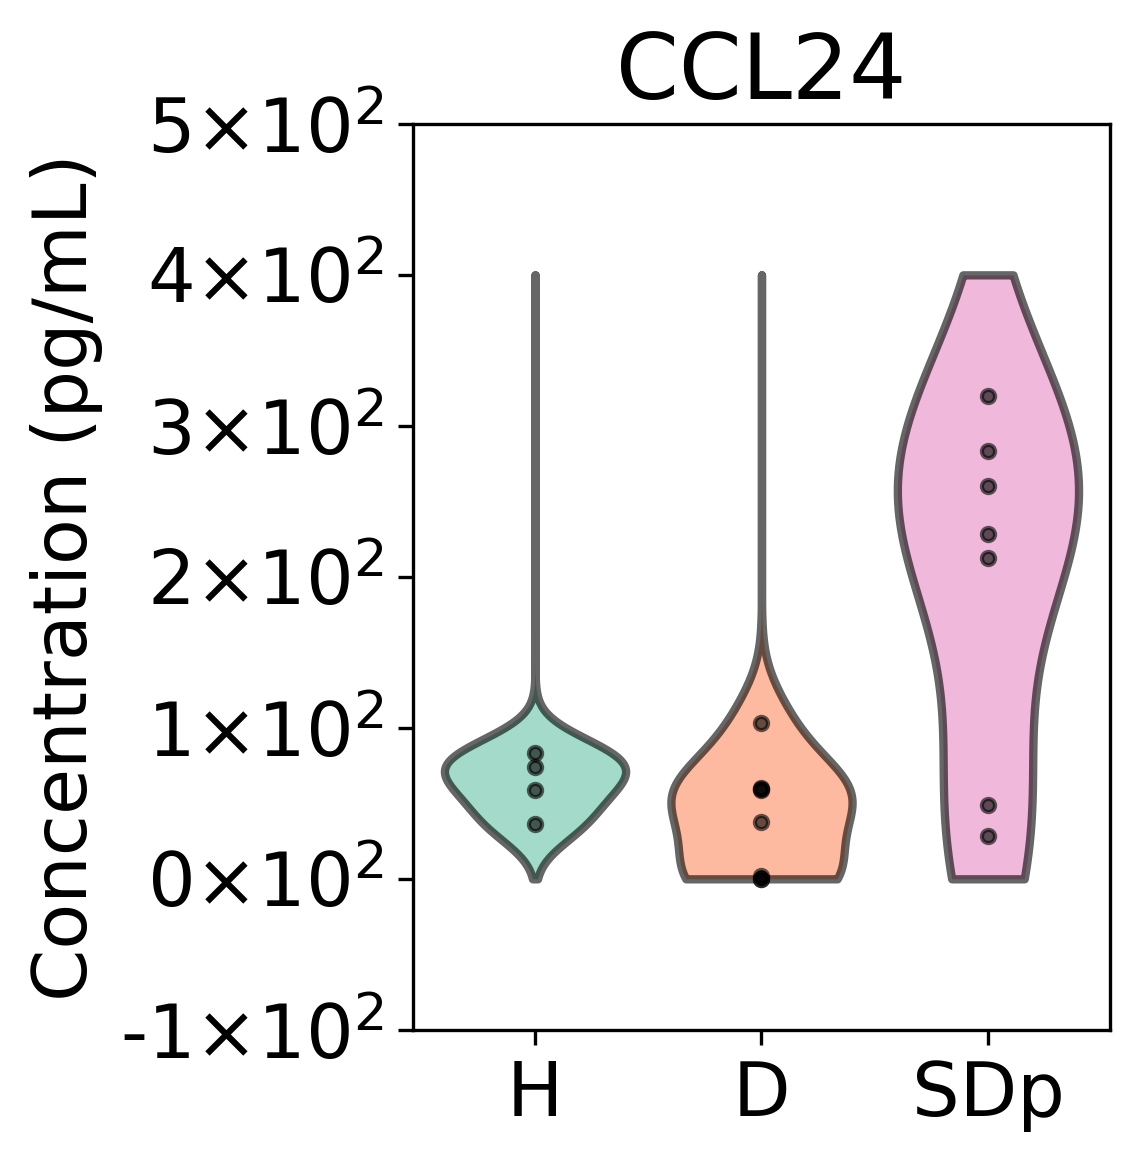

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

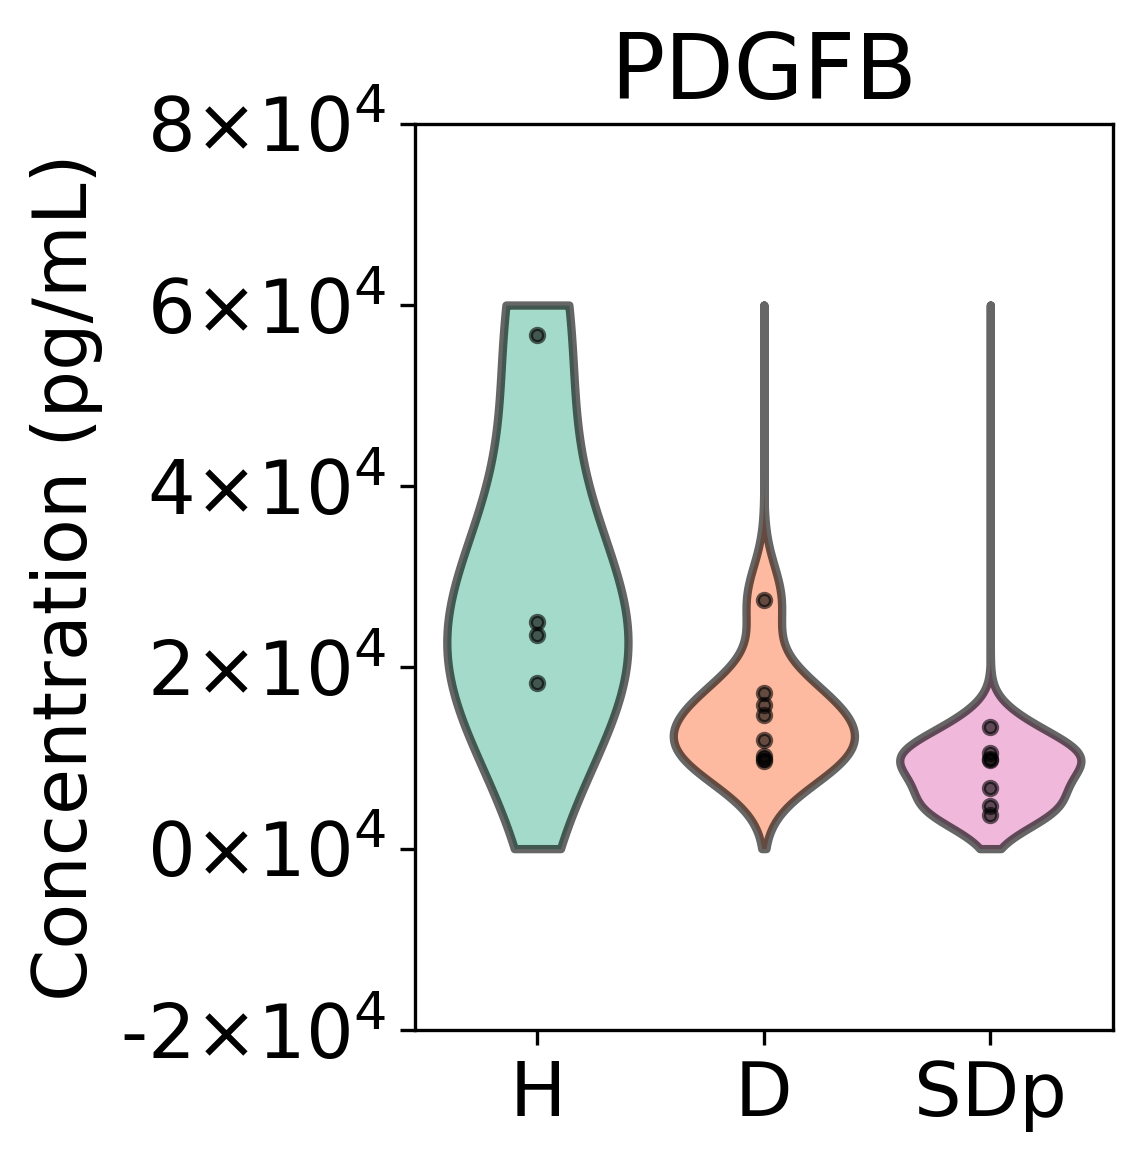

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

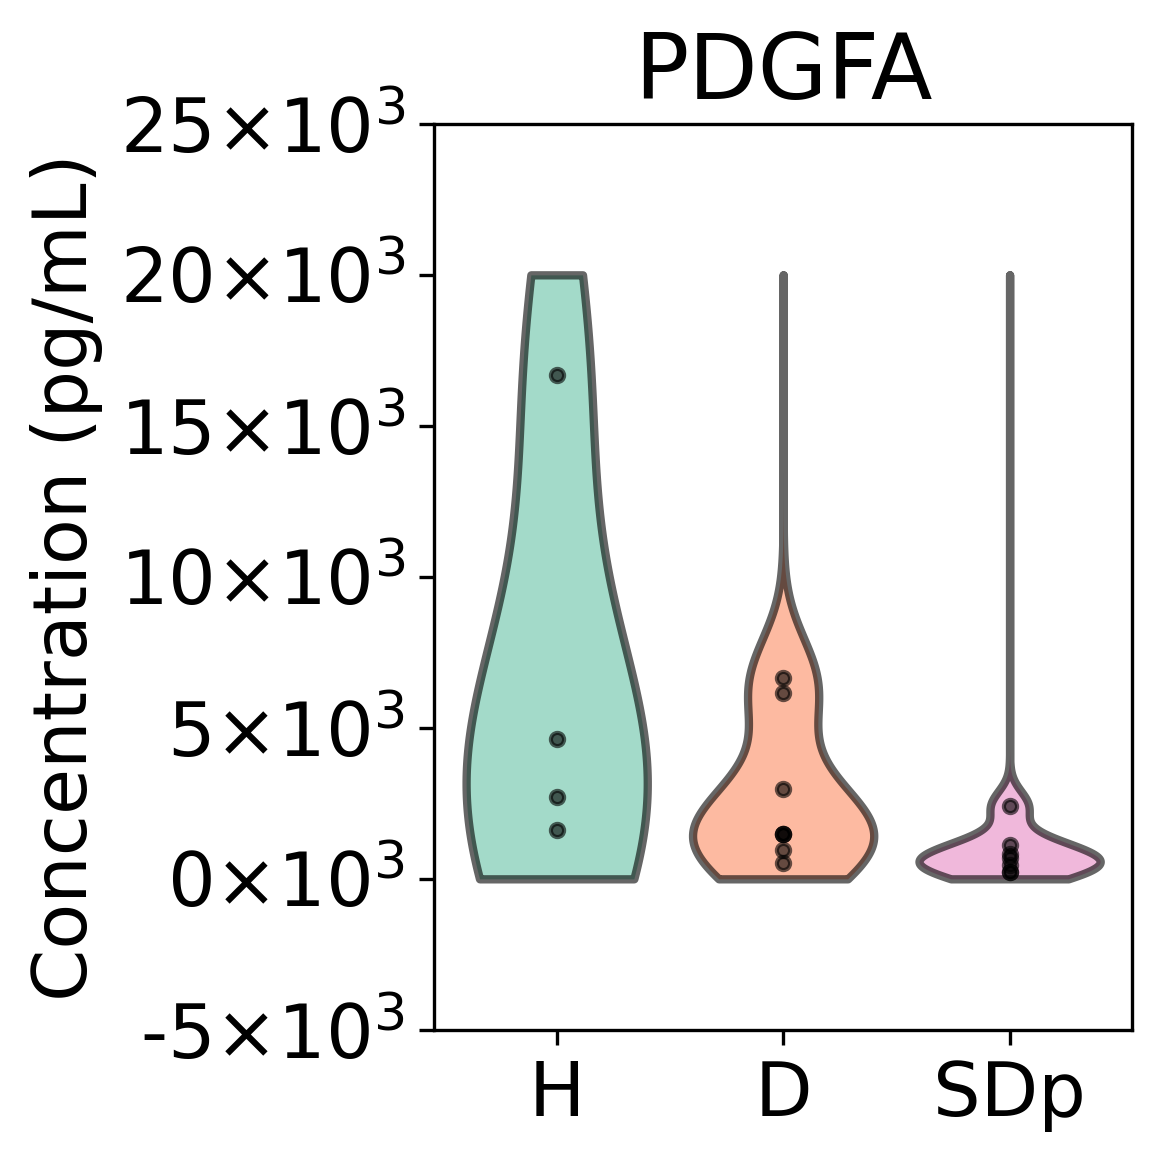

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

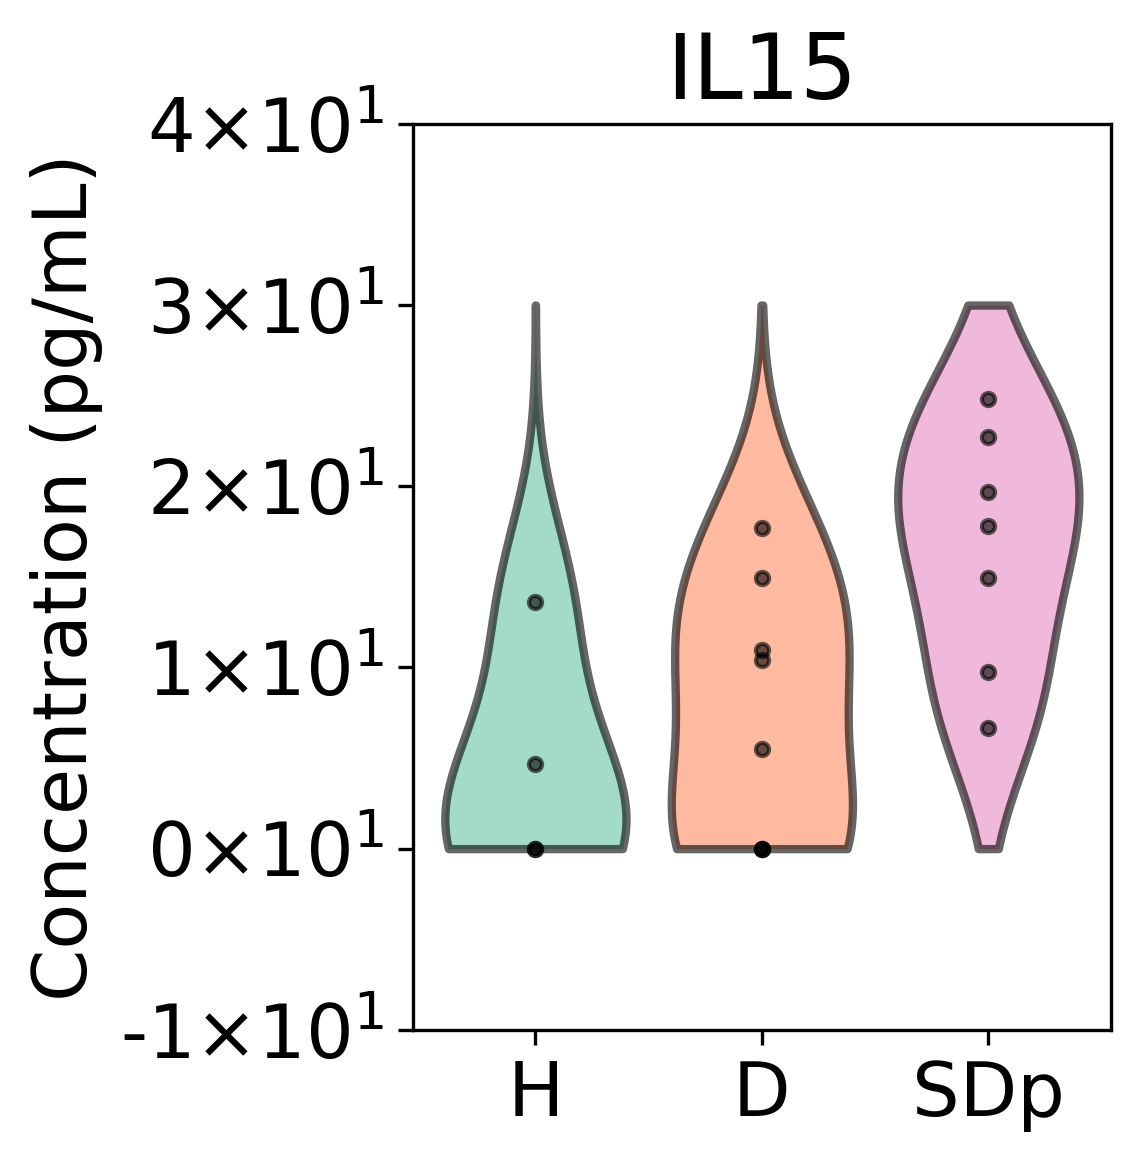

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

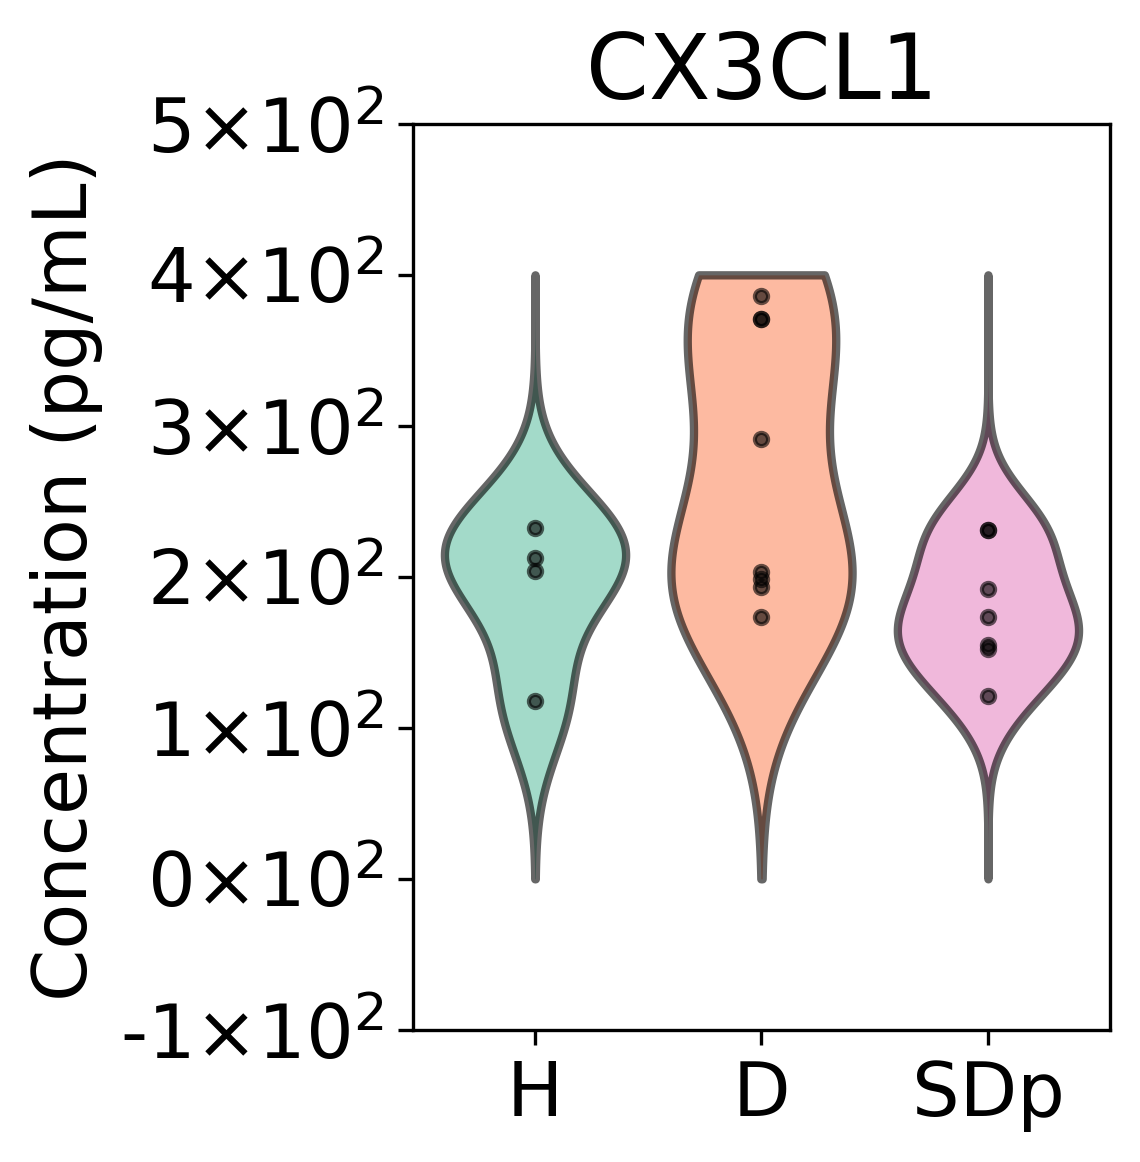

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

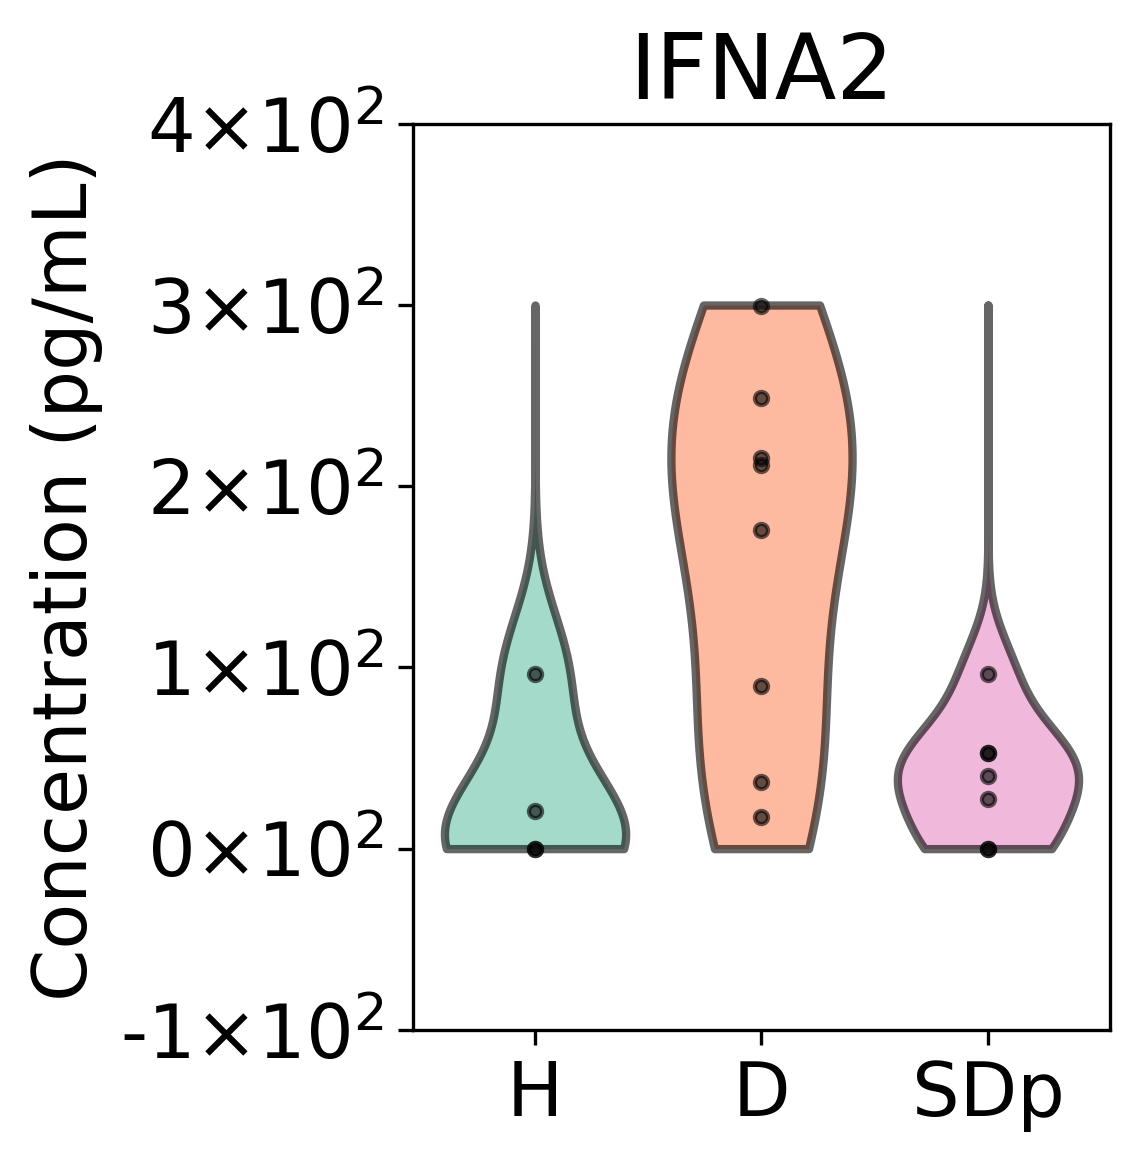

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

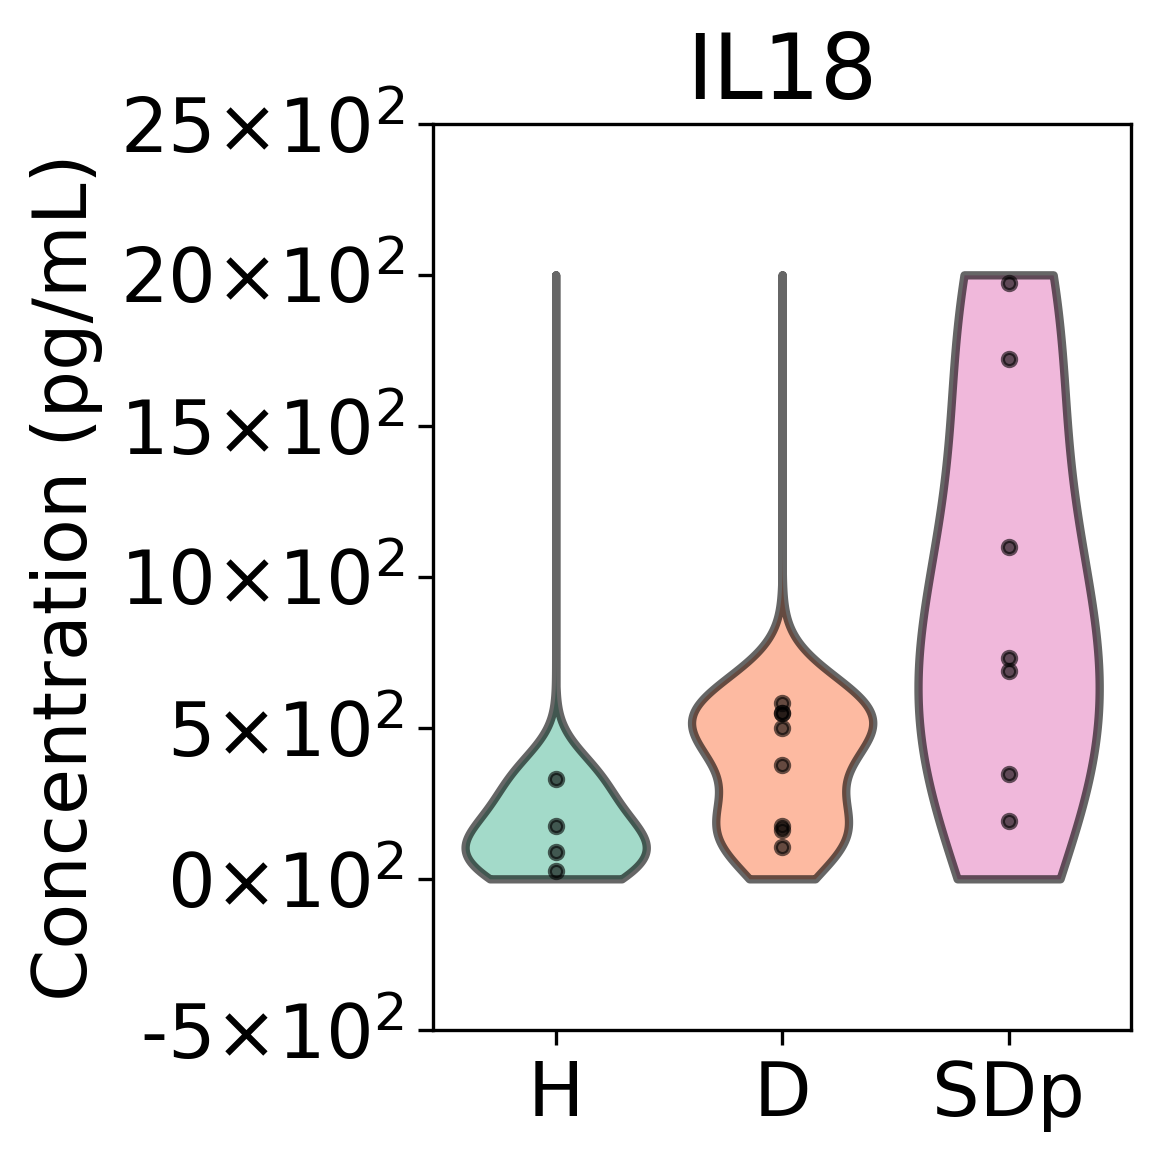

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

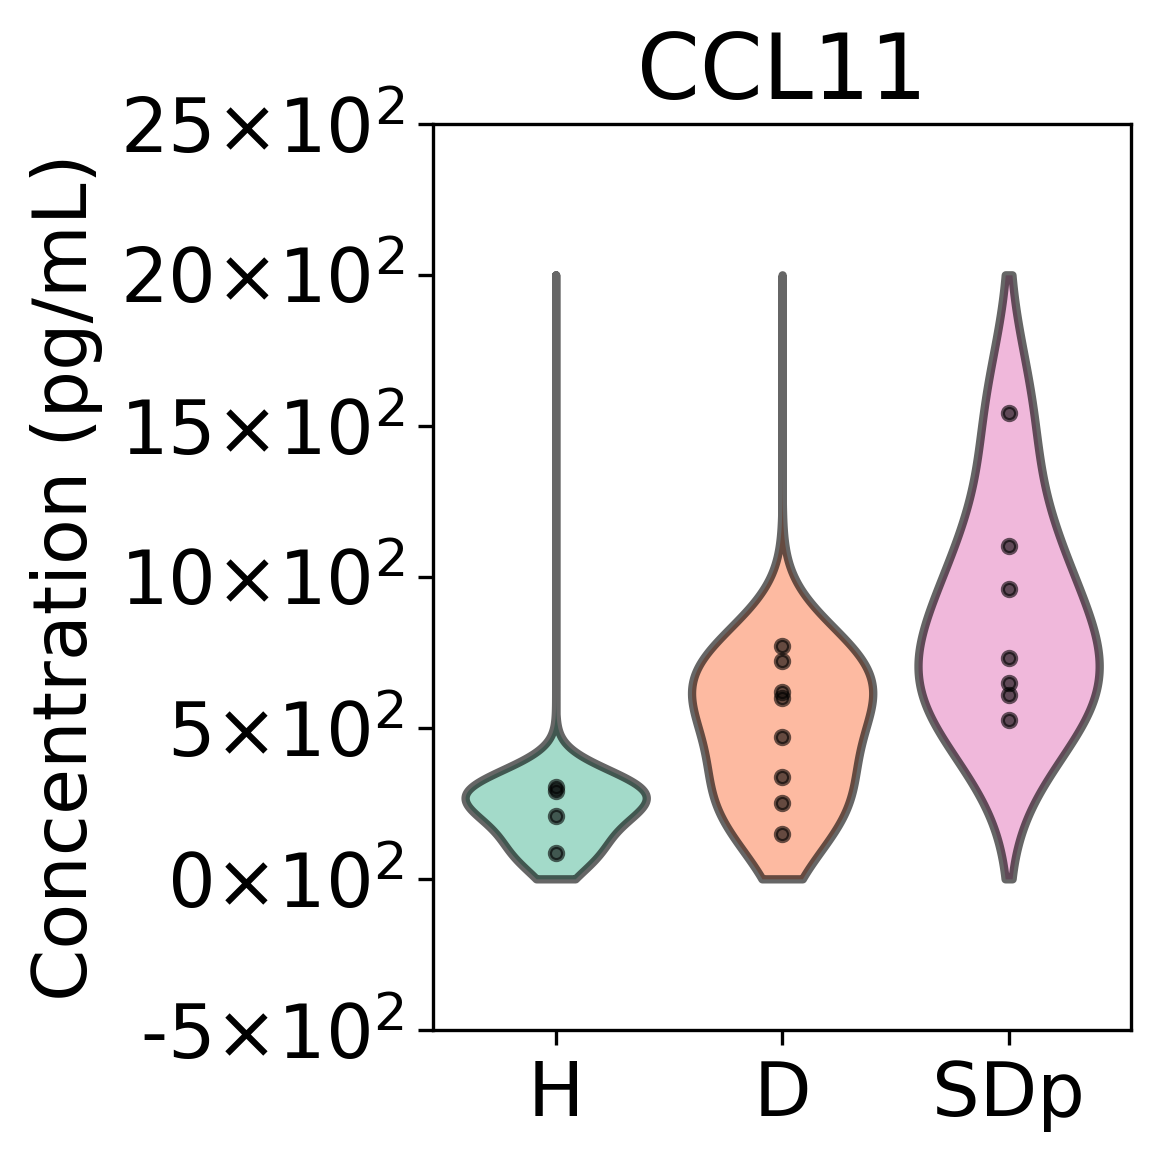

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

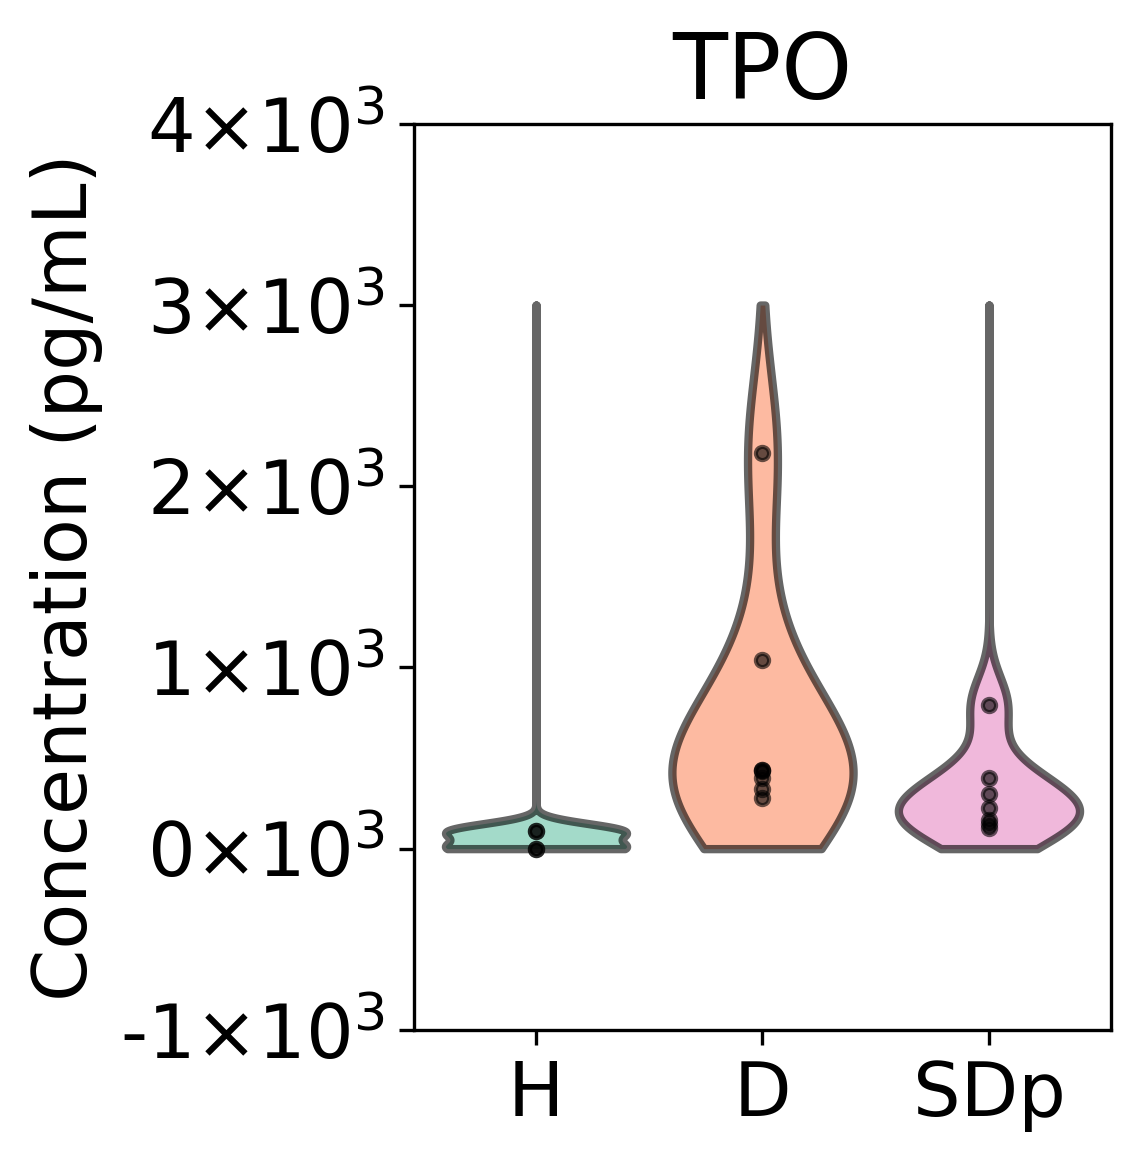

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

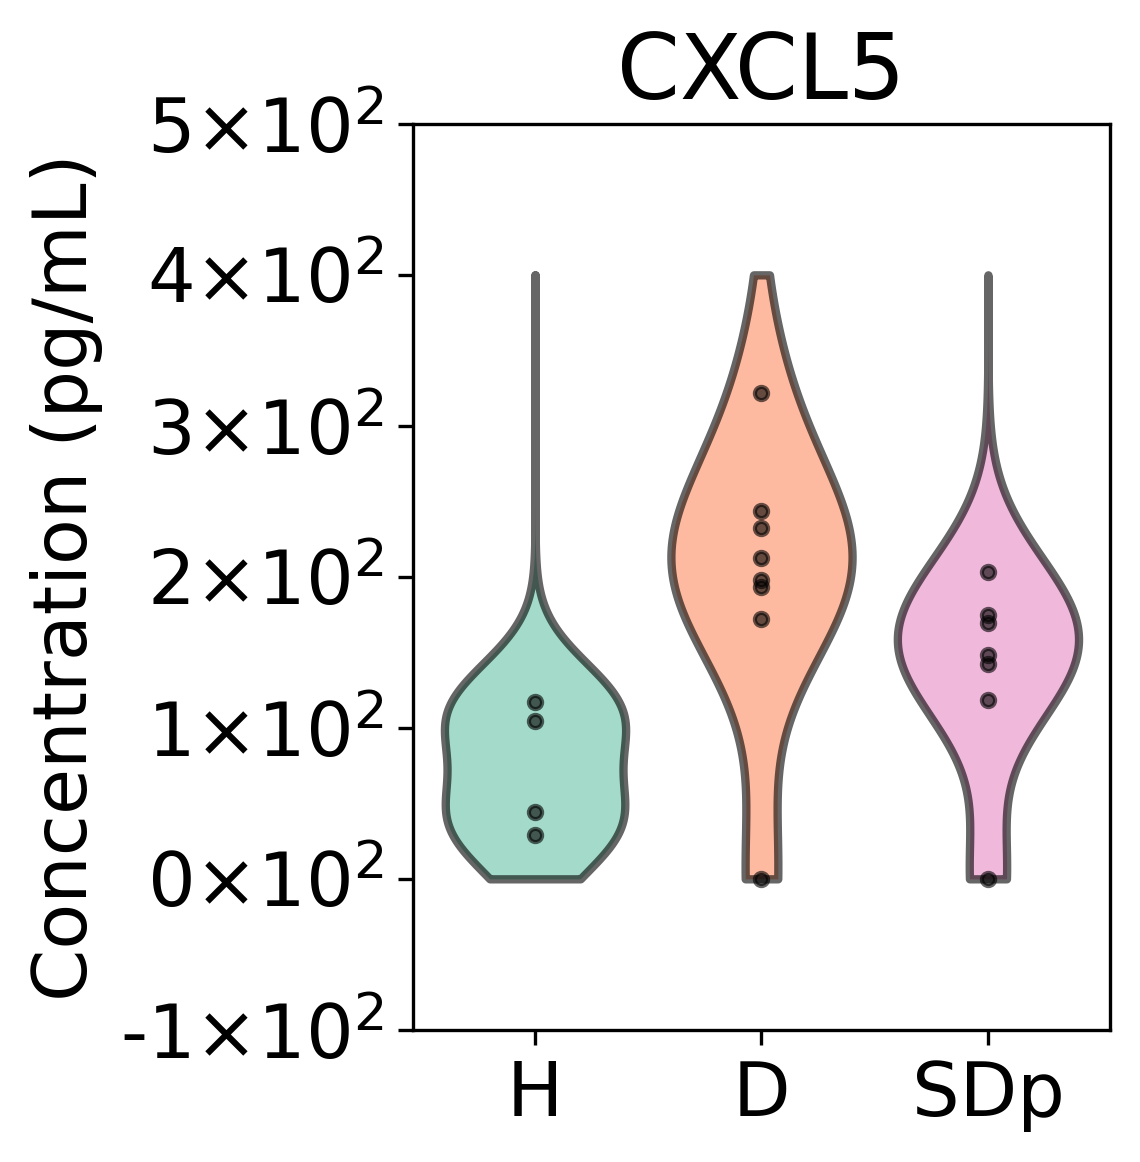

In [64]:
res = res.reset_index()
res['Condition'] = res['Condition'].replace({'SD': 'SDp'})
res = res.set_index(['Condition', 'ID'])
if True:
    for cyto in pair.loc[sig_cytos].sort_values('pvalue_U').index:

        fig2 = cyto_violin_new(res, cyto)['fig']
        fig2.savefig(save_figures + 'violin_plots/' + cyto + '.pdf', bbox_inches='tight')

In [29]:
res_sig = res[['IFNG', 'IL10', 'CCL2', 'TNF', 'FASLG', 'FAS']].loc[['H', 'D', 'SD']]
# res_sig.to_csv('/home/yike/phd/dengue/docs/nature_immunology_review/20230831_accepted/Source_data/Fig. 5f.tsv', sep='\t')

In [32]:
from scipy.stats import mannwhitneyu
stats_u = []
pvalue_u = []
for gene in res_sig.columns:
    s, p = mannwhitneyu(res.loc['H'][gene].tolist(), res.loc['SD'][gene].tolist(), alternative='two-sided',)
    stats_u.append(s)
    pvalue_u.append(p)

In [33]:
stats_u

[2.0, 0.0, 0.0, 0.0, 3.0, 2.0]

In [34]:
pvalue_u

[0.024242424242424242,
 0.009019924166363722,
 0.006060606060606061,
 0.006060606060606061,
 0.04242424242424242,
 0.024242424242424242]

In [82]:
def com_mushrooms(genes, cst_plots, vmax=3):

    from matplotlib.patches import Wedge
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    import math
    import numpy as np
    import pandas as pd
    import itertools

    conditions = ['SD', 'N']
    cmap = plt.cm.get_cmap('viridis')
    vmin = -1
    # vmax = 3
    threshold = 0.2

    #save_tabels = '/home/yike/phd/dengue/data/tables/dataset_20211001/'
    frac_ct = pd.read_csv('/home/yike/phd/dengue/docs/paper_draft/tabels/exclude_1_075_01/ct_fra.tsv', 
                         sep='\t', index_col=['cell_type_new', 'condition', 'gene']).squeeze(1)
    avg_ct = pd.read_csv('/home/yike/phd/dengue/docs/paper_draft/tabels/exclude_1_075_01/ct_avg.tsv', 
                         sep='\t', index_col=['cell_type_new', 'condition', 'gene']).squeeze(1)

    frac_cst = pd.read_csv('/home/yike/phd/dengue/docs/paper_draft/tabels/exclude_1_075_01/cst_fra.tsv', 
                          sep='\t', index_col=['cell_subtype_new', 'condition', 'gene']).squeeze(1)
    avg_cst = pd.read_csv('/home/yike/phd/dengue/docs/paper_draft/tabels/exclude_1_075_01/cst_avg.tsv', 
                          sep='\t', index_col=['cell_subtype_new', 'condition', 'gene']).squeeze(1)

    if len(cst_plots) < 5:
        length = 5
    else:
        length = len(cst_plots)

    fig = plt.figure(figsize=(2 + 0.5 * len(genes), 1 + length * 0.6), dpi=300)
    grid = plt.GridSpec(1 , len(genes) + 1, wspace=0.15, hspace=0.1)

    # fig, axs = plt.subplots(1, len(genes) + 1, 
    #                         figsize=((1 + 0.48 * len(genes)), (1 + length)* 0.6), dpi=300)

    cell_types = ['Monocytes', 'NK cells', 'Plasmablasts', 'B cells', 'T cells', 
                  'conventional DCs', 'plasmacytoid DCs','megakaryocytes', ]

    cell_subtypes = [
                     'classical monocytes',
                     'non-classical monocytes',
                     'intermediate monocytes',

                     'cytotoxic NK cells',
                     'signaling NK cells',

                     'proliferating plasmablasts',
                     'non-proliferating plasmablasts',

                     'naive B cells',
                     'memory B cells',
                     'activated B cells',

                     'CD4+ naive T cells',
                     'CD4+ memory T cells',
                     'CD8+ naive T cells',
                     'CD8+ effector memory T cells',
                     'CD8+ exhausted T cells',
                     'MAIT',
                     'Tregs',

                     'cDC1',
                     'cDC2',
                     'pDCs',]
    
    axs = []
    for i in range(len(genes)):
         axs.append(plt.subplot(grid[0: len(cst_plots), i: i+1]))

    axs.append(plt.subplot(grid[0: 5, len(genes): len(genes) + 1])) # size_bar

    for gene, ax in zip(genes, axs[:-1]):
        datap = []
        yticklabels = []
        for cst in cst_plots:
            avgs = []
            yticklabels.append(cst.replace('_', ' '))
            for k, cond in enumerate(conditions):
                if cst in cell_types:
                    fr = frac_ct.loc[(cst, cond, gene)]
                    av = np.log10(avg_ct.loc[(cst, cond, gene)] + 0.1)
                elif cst in cell_subtypes:
                    fr = frac_cst.loc[(cst, cond, gene)]
                    av = np.log10(avg_cst.loc[(cst, cond, gene)] + 0.1)
                avgs.append(av)
                r = 0.5 * fr**0.3
                color = cmap((min(vmax, av) - vmin) / (vmax - vmin))
                theta0, theta1 = 180 * (k > 0), 180 + 180 * (k > 0)
                datap.append({
                    'r': r,
                    'facecolor': color,
                    'center': (0, len(yticklabels)-1),
                    'theta': (theta0, theta1),
                    'ax': ax,
                })
            if avgs[0] - avgs[1] > threshold:
                datap[-2]['edgecolor'] = 'red'
                datap[-1]['edgecolor'] = 'none'
            elif avgs[0] - avgs[1] < -threshold:
                datap[-1]['edgecolor'] = 'red'
                datap[-2]['edgecolor'] = 'none'
            else:
                datap[-1]['edgecolor'] = 'none'
                datap[-2]['edgecolor'] = 'none'   

        ax.set_title(gene, fontsize=8)

        if ax == axs[0]:
            ax.set_yticks(np.arange(len(cst_plots)))
            ax.set_yticklabels(yticklabels, fontsize=10)
        else:
            ax.set_yticks([])
            ax.set_yticklabels([])

        ax.set_ylim(-0.6, len(cst_plots) - 0.4)        
        ax.set_xticks([])
        ax.set_xlim(-0.6, 1 - 0.4)

        for datum in datap:
            ax = datum['ax']
            r = datum['r']
            color = datum['facecolor']
            center = datum['center']
            theta0, theta1 = datum['theta']
            ec = datum['edgecolor']

            h = Wedge(
                center, r, theta0, theta1, facecolor=color, edgecolor=ec
            )
            ax.add_artist(h)
            ax.set_aspect(1)

    axs[-1].set_ylim(-0.6, 5 - 0.4)        
    c = [(0.5, i) for i in range(5)]
    radius = [0.5 * fr**0.3 for fr in [0.05, 0.1, 0.2, 0.4, 0.8]]
    for c, r in zip(c, radius):
        e = Wedge(c, r, 0, 180, facecolor='gray',)
        axs[-1].add_artist(e)
    axs[-1].set_aspect(1)
    axs[-1].set_yticks([])
    axs[-1].set_yticks(range(5))
    axs[-1].set_yticklabels(['5', '10', '20', '40', '80'])
    axs[-1].yaxis.tick_right()
    axs[-1].yaxis.set_label_position('right')
    axs[-1].set_ylabel('Gene exp frac')
    axs[-1].set_xticks([])
    axs[-1].spines['bottom'].set_visible(False)
    axs[-1].spines['top'].set_visible(False)
    axs[-1].spines['right'].set_visible(False)
    axs[-1].spines['left'].set_visible(False)

    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax) 
    cmap = plt.cm.get_cmap('viridis')
    position = fig.add_axes([0.98, 0.4, 0.01, 0.3]) 
    # The dimensions [left, bottom, width, height] of the new Axes.
    # All quantities are in fractions of figure width and height.
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[-1], cax=position, 
                        label='Gene exp \n(log10[cpm+0.1])')

    fig.tight_layout()
    
    return {'figure': fig, 'axs': axs}

<ipython-input-82-d815bbea57f8>:163: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

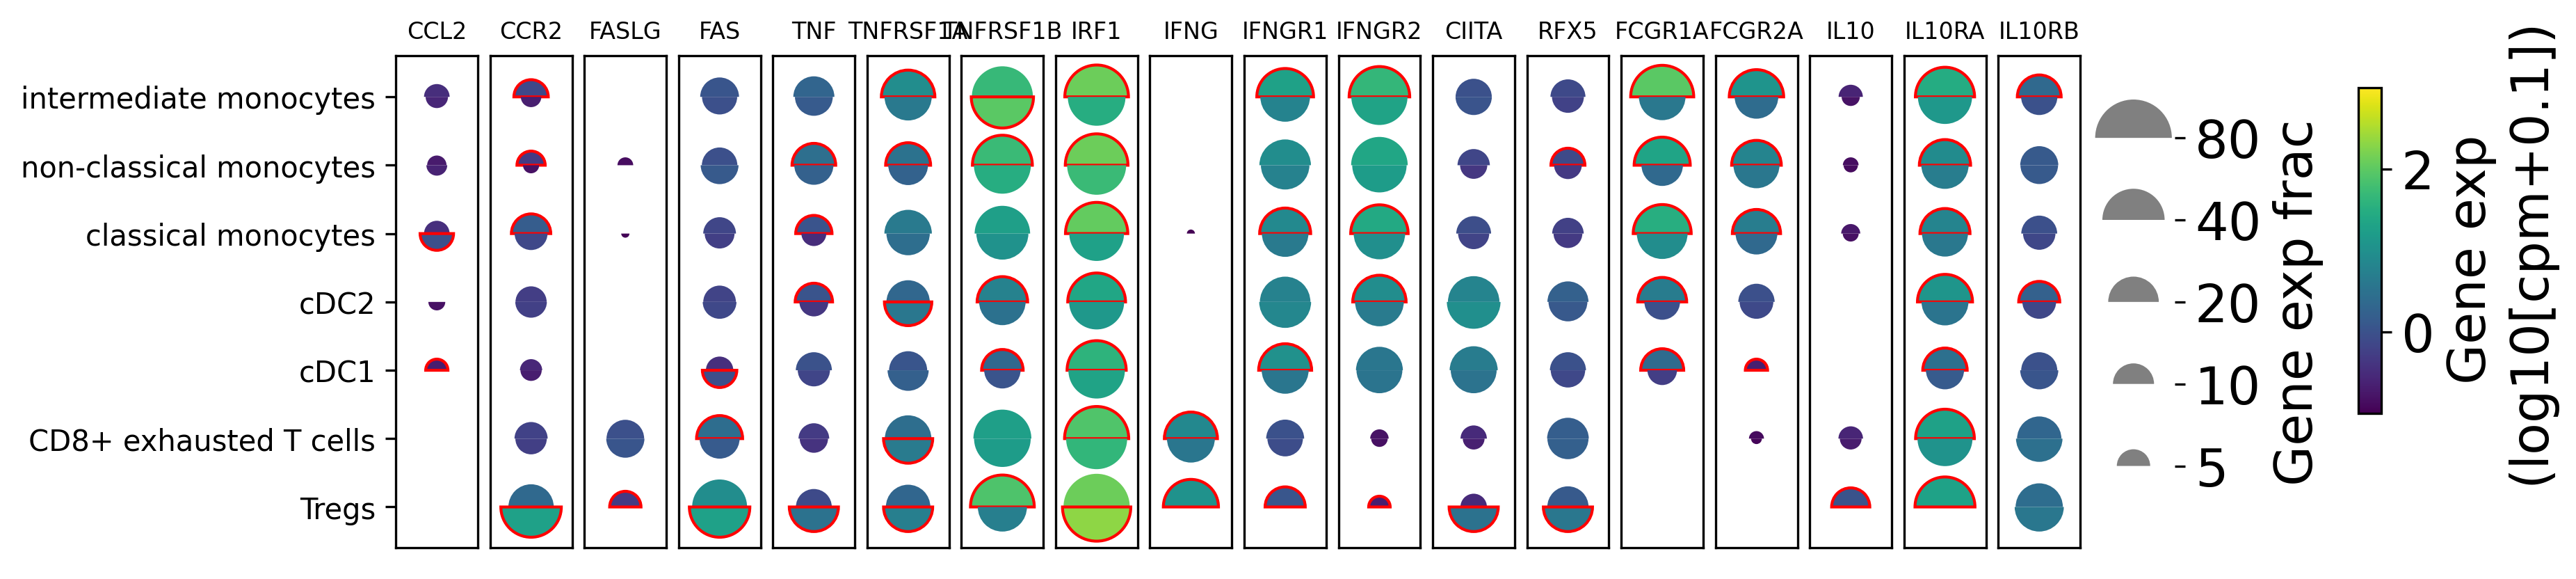

In [83]:
csts_plot = ['Tregs', 'CD8+ exhausted T cells', 'cDC1', 'cDC2', 
             'classical monocytes', 'non-classical monocytes', 'intermediate monocytes']
fig = com_mushrooms(['CCL2', 'CCR2', 
                     'FASLG', 'FAS',
                     'TNF', 'TNFRSF1A', 'TNFRSF1B', 'IRF1', 
                     'IFNG', 'IFNGR1', 'IFNGR2', 'CIITA', 'RFX5',
                     'FCGR1A', 'FCGR2A', 
#                      'HLA-DPA1', 'HLA-DQA1', 'HLA-DQB1', 'HLA-DRB1', 'HLA-DRB5',
                     'IL10', 'IL10RA', 'IL10RB'], 
              csts_plot, vmax=3)['figure']
fig.savefig(save_figures + 'mushroom_some_csts.svg')